In [1]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import copy
from netCDF4 import Dataset, num2date, date2num
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import cm
from scipy.optimize import curve_fit


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import linregress
import ruptures as rpt
import statsmodels.api as sm

In [2]:
import scipy
import scipy.stats as ss
import scipy.signal
from scipy.interpolate import griddata
from scipy.signal import argrelmin
from scipy.ndimage import interpolation
from scipy.stats import genextreme as gev
import scipy.stats.mstats as mstats
import math
from math import log10, floor
import os
import dask.diagnostics as dd
import dask.array as da
from dask.diagnostics import ProgressBar
pbar = ProgressBar() 
import seaborn as sns
from sklearn import linear_model
import pickle

In [3]:
def remove_seasonal(var,yearN,stepN):
    var_re = np.zeros_like(var)*0.0
    for i_box in range(stepN):
        temp1 = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        if (i_box>=2)&(i_box<=stepN-3):
            temp = []
            for i_year in range(0, yearN):
                temp.extend(var[stepN*i_year+i_box-2:stepN*i_year+i_box+3] )
            temp = np.array(temp)
        elif i_box<2:
            temp = []
            temp.extend(var[0:5])
            for i_year in range(1, yearN):
                temp.extend(var[stepN*i_year+i_box-2:stepN*i_year+i_box+3] )
            temp = np.array(temp)
        else:
            temp = []
            for i_year in range(0, yearN-1):
                temp.extend(var[stepN*i_year+i_box-2:stepN*i_year+i_box+3] )
            temp.extend(var[-5:])
            temp = np.array(temp)
            
        temp1 = temp1 - np.array(len(temp1)*[np.nanmean(temp,axis=0)])

        for i_year in range(yearN):
            var_re[stepN*i_year+i_box]  = temp1[i_year]
    return var_re

def detrend(var,yearN,stepN):
    var_detrend = np.zeros_like(var)*0.0
    for i_year in range(yearN):
        temp = np.array(var[stepN*i_year:stepN*i_year+stepN] )
        if i_year in range(2,yearN-2):
            temp1 = np.nanmean(np.array(var[stepN*(i_year-2):stepN*(i_year+3)] ),axis=0)
        elif i_year in range(2):
            temp1 = np.nanmean(np.array(var[:stepN*5] ),axis=0)
        else:
            temp1 = np.nanmean(np.array(var[-stepN*5:] ),axis=0)

        temp = temp - np.array(len(temp)*[temp1])
        
        var_detrend[stepN*i_year:stepN*i_year+stepN]  = temp
    return var_detrend


In [4]:
def standard(var,yearN,stepN):
    return (var-np.nanmean(var))/np.nanstd(var)
def standard_re(var,yearN,stepN):
    return (var-np.nanmean(var))/np.nanstd(var),np.nanmean(var),np.nanstd(var)

# load data: sub_region

In [5]:

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_T2mmax_1950_2023_del29_3dmean_ERAland.nc')
t2m_large = np.squeeze(NCData.variables['var167'][:])
lon_WEU= NCData.variables['lon'][:]
lat_WEU = NCData.variables['lat'][:]
LON_WEU, LAT_WEU = np.meshgrid(lon_WEU, lat_WEU)
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


In [6]:
startyear = 1950
yearindex = np.where(year_era5>=startyear)[0]
year_era5 = year_era5[yearindex]
mon_era5 = mon_era5[yearindex]
day_era5 = day_era5[yearindex]

yearN = 2023-startyear+1
stepN = np.int(len(year_era5)/yearN)
t2m_large = t2m_large[yearindex]
t2m_large_re = copy.deepcopy(remove_seasonal(t2m_large,yearN,stepN))
t2m_large_re_de = copy.deepcopy(detrend(t2m_large_re,yearN,stepN))
t2m_large_re_de_std = copy.deepcopy(standard(t2m_large_re_de,yearN,stepN))

In [7]:
lon_WEU

masked_array(data=[-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,
                    2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
                   13., 14.],
             mask=False,
       fill_value=1e+20)

In [8]:
lat_WEU

masked_array(data=[55., 54., 53., 52., 51., 50., 49., 48., 47., 46., 45.,
                   44., 43., 42., 41., 40., 39., 38., 37.],
             mask=False,
       fill_value=1e+20)

In [9]:

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_land_sea_mask_2023_01_01_1x1.nc')
land_mask = np.squeeze(NCData.variables['var172'][:])
lon_WEU1= NCData.variables['lon'][:]
lat_WEU1 = NCData.variables['lat'][:]
LON_WEU1, LAT_WEU1 = np.meshgrid(lon_WEU1, lat_WEU1)
NCData.close()

In [10]:
#### CEU boundary
bnd_l = 0
bnd_r = bnd_l+14
bnd_b = 44
bnd_u =bnd_b+10


# data process: region_mean

In [11]:
NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_T2mmax_1950_2023_del29_3dmean_ERAland.nc')
t2m = np.squeeze(NCData.variables['var167'][:])
lon_WEU= NCData.variables['lon'][:]
lat_WEU = NCData.variables['lat'][:]
LON_WEU, LAT_WEU = np.meshgrid(lon_WEU, lat_WEU)
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_Z500_1950_2023_del29_3dmean.nc')
Z200 = np.squeeze(NCData.variables['var129'][:])/9.81
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_swvl1_1950_2023_del29_3dmean_ERAland.nc')
SM = np.squeeze(NCData.variables['var39'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


In [12]:

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_OLR_1950_2023_del29_3dmean.nc')
OLR = np.squeeze(NCData.variables['var179'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_tot_precip_1950_2023_del29_3dmean.nc')
TP = np.squeeze(NCData.variables['var228'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_T2m_dew_1950_2023_del29_3dmean.nc')
T2m_dew = np.squeeze(NCData.variables['var168'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_surface_pressure_1950_2023_del29_3dmean.nc')
ps = np.squeeze(NCData.variables['var134'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_surface_sensible_heat_flux_1950_2023_del29_3dmean.nc')
S_SH = -np.squeeze(NCData.variables['var146'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()
NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_surface_latent_heat_flux_1950_2023_del29_3dmean.nc')
S_LH = -np.squeeze(NCData.variables['var147'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

In [13]:
NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_surface_latent_heat_flux_1950_2023_del29_3dmean.nc')
S_LH = -np.squeeze(NCData.variables['var147'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

In [14]:
VP = 6.112*np.exp(17.67*(T2m_dew -272.15)/(T2m_dew -272.15+243.5))
qq = 0.622*VP/(ps/100-0.378*VP)
EF = S_LH/(S_SH+S_LH)

In [15]:
JJA_index = np.where(np.in1d(mon_era5,[6,7,8]))[0]
after_1979 = np.where(year_era5[JJA_index]>=1979)[0]

# data process: remove seasaonal cycle and detrend

In [12]:
startyear = 1950
yearindex = np.where(year_era5>=startyear)[0]
year_era5 = year_era5[yearindex]
mon_era5 = mon_era5[yearindex]
day_era5 = day_era5[yearindex]

yearN = 2023-startyear+1
stepN = np.int(len(year_era5)/yearN)

In [13]:
Z200_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in Z200])[yearindex]
Z200_region_re = copy.deepcopy(remove_seasonal(Z200_region,yearN,stepN))
Z200_region_re_std = copy.deepcopy(standard(Z200_region_re,yearN,stepN))
Z200_region_re_de = copy.deepcopy(detrend(Z200_region_re,yearN,stepN))
Z200_region_re_de_std = copy.deepcopy(standard(Z200_region_re_de,yearN,stepN))
Z200_ave1 = copy.deepcopy(standard_re(Z200_region_re_de,yearN,stepN))[1]
Z200_std1 = copy.deepcopy(standard_re(Z200_region_re_de,yearN,stepN))[2]

In [14]:
SM_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in SM])[yearindex]
SM_region_re = copy.deepcopy(remove_seasonal(SM_region,yearN,stepN))
SM_region_re_std = copy.deepcopy(standard(SM_region_re,yearN,stepN))
SM_region_re_de = copy.deepcopy(detrend(SM_region_re,yearN,stepN))
SM_region_re_de_std = copy.deepcopy(standard(SM_region_re_de,yearN,stepN))
SM_ave1 = copy.deepcopy(standard_re(SM_region_re_de,yearN,stepN))[1]
SM_std1 = copy.deepcopy(standard_re(SM_region_re_de,yearN,stepN))[2]

In [15]:
t2m_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in t2m])[yearindex]
t2m_region_re = copy.deepcopy(remove_seasonal(t2m_region,yearN,stepN))
t2m_region_re_std = copy.deepcopy(standard(t2m_region_re,yearN,stepN))
t2m_region_re_de = copy.deepcopy(detrend(t2m_region_re,yearN,stepN))
t2m_region_re_de_std = copy.deepcopy(standard(t2m_region_re_de,yearN,stepN))
t2m_ave1 = copy.deepcopy(standard_re(t2m_region_re_de,yearN,stepN))[1]
t2m_std1 = copy.deepcopy(standard_re(t2m_region_re_de,yearN,stepN))[2]

In [20]:
OLR_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in OLR])[yearindex]
OLR_region_re = copy.deepcopy(remove_seasonal(OLR_region,yearN,stepN))
OLR_region_re_std = copy.deepcopy(standard(OLR_region_re,yearN,stepN))
OLR_region_re_de = copy.deepcopy(detrend(OLR_region_re,yearN,stepN))
OLR_region_re_de_std = copy.deepcopy(standard(OLR_region_re_de,yearN,stepN))
OLR_ave1 = copy.deepcopy(standard_re(OLR_region_re_de,yearN,stepN))[1]
OLR_std1 = copy.deepcopy(standard_re(OLR_region_re_de,yearN,stepN))[2]

In [21]:
TP_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in TP])[yearindex]
TP_region_re = copy.deepcopy(remove_seasonal(TP_region,yearN,stepN))
TP_region_re_std = copy.deepcopy(standard(TP_region_re,yearN,stepN))
TP_region_re_de = copy.deepcopy(detrend(TP_region_re,yearN,stepN))
TP_region_re_de_std = copy.deepcopy(standard(TP_region_re_de,yearN,stepN))
TP_ave1 = copy.deepcopy(standard_re(TP_region_re_de,yearN,stepN))[1]
TP_std1 = copy.deepcopy(standard_re(TP_region_re_de,yearN,stepN))[2]

In [22]:
T2m_dew_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in T2m_dew])[yearindex]
T2m_dew_region_re = copy.deepcopy(remove_seasonal(T2m_dew_region,yearN,stepN))
T2m_dew_region_re_std = copy.deepcopy(standard(T2m_dew_region_re,yearN,stepN))
T2m_dew_region_re_de = copy.deepcopy(detrend(T2m_dew_region_re,yearN,stepN))
T2m_dew_region_re_de_std = copy.deepcopy(standard(T2m_dew_region_re_de,yearN,stepN))
T2m_dew_ave1 = copy.deepcopy(standard_re(T2m_dew_region_re_de,yearN,stepN))[1]
T2m_dew_std1 = copy.deepcopy(standard_re(T2m_dew_region_re_de,yearN,stepN))[2]

In [23]:
qq_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in qq])[yearindex]
qq_region_re = copy.deepcopy(remove_seasonal(qq_region,yearN,stepN))
qq_region_re_std = copy.deepcopy(standard(qq_region_re,yearN,stepN))
qq_region_re_de = copy.deepcopy(detrend(qq_region_re,yearN,stepN))
qq_region_re_de_std = copy.deepcopy(standard(qq_region_re_de,yearN,stepN))
qq_ave1 = copy.deepcopy(standard_re(qq_region_re_de,yearN,stepN))[1]
qq_std1 = copy.deepcopy(standard_re(qq_region_re_de,yearN,stepN))[2]

In [24]:
S_LH_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in S_LH])[yearindex]

S_LH_region_re = copy.deepcopy(remove_seasonal(S_LH_region,yearN,stepN))
S_LH_region_re_std = copy.deepcopy(standard(S_LH_region_re,yearN,stepN))
S_LH_region_re_de = copy.deepcopy(detrend(S_LH_region_re,yearN,stepN))
S_LH_region_re_de_std = copy.deepcopy(standard(S_LH_region_re_de,yearN,stepN))
S_LH_ave1 = copy.deepcopy(standard_re(S_LH_region_re_de,yearN,stepN))[1]
S_LH_std1 = copy.deepcopy(standard_re(S_LH_region_re_de,yearN,stepN))[2]

In [25]:
S_SH_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in S_SH])[yearindex]

S_SH_region_re = copy.deepcopy(remove_seasonal(S_SH_region,yearN,stepN))
S_SH_region_re_std = copy.deepcopy(standard(S_SH_region_re,yearN,stepN))
S_SH_region_re_de = copy.deepcopy(detrend(S_SH_region_re,yearN,stepN))
S_SH_region_re_de_std = copy.deepcopy(standard(S_SH_region_re_de,yearN,stepN))
S_SH_ave1 = copy.deepcopy(standard_re(S_SH_region_re_de,yearN,stepN))[1]
S_SH_std1 = copy.deepcopy(standard_re(S_SH_region_re_de,yearN,stepN))[2]

In [26]:
NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_radiation_1950_2023_1.x1._1h_ERAland_3d.nc')
# Tskin_land = np.squeeze(NCData.variables['var235'][:])
S_LH_land = np.squeeze(NCData.variables['var147'][:])
Rs_land = np.squeeze(NCData.variables['var176'][:])
S_SH_land = np.squeeze(NCData.variables['var146'][:])
Rld_land = np.squeeze(NCData.variables['var175'][:])


lon_WEU_land = NCData.variables['lon'][:]
lat_WEU_land = NCData.variables['lat'][:]
LON_WEU_land, LAT_WEU_land = np.meshgrid(lon_WEU_land, lat_WEU_land)
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5_land = np.array([date.year for date in dates])
mon_era5_land = np.array([date.month for date in dates])
day_era5_land = np.array([date.day for date in dates])
NCData.close()

# Tskin_land = np.concatenate((Tskin_land[121:121+10],Tskin_land))
S_LH_land = np.concatenate((S_LH_land[121:121+10],S_LH_land))
Rs_land = np.concatenate((Rs_land[121:121+10],Rs_land))
S_SH_land = np.concatenate((S_SH_land[121:121+10],S_SH_land))
Rld_land = np.concatenate((Rld_land[121:121+10],Rld_land))

In [27]:
S_LH_land[S_LH_land==-9.e+33]=np.nan
Rs_land[Rs_land==-9.e+33]=np.nan
S_SH_land[S_SH_land==-9.e+33]=np.nan
Rld_land[Rld_land==-9.e+33]=np.nan

In [28]:
EF = S_LH_land/(S_LH_land+S_SH_land)
EF_region = np.array([np.nanmean(i[(LON_WEU_land>=bnd_l)&(LON_WEU_land<=bnd_r)&(LAT_WEU_land>=bnd_b)&(LAT_WEU_land<=bnd_u)]) for i in EF])[yearindex]
EF_region[EF_region>1]=1
EF_region[EF_region<0]=0
EF_region_re = copy.deepcopy(remove_seasonal(EF_region,yearN,stepN))
EF_region_re_std = copy.deepcopy(standard(EF_region_re,yearN,stepN))
EF_region_re_de = copy.deepcopy(detrend(EF_region_re,yearN,stepN))
EF_region_re_de_std = copy.deepcopy(standard(EF_region_re_de,yearN,stepN))
EF_ave1 = copy.deepcopy(standard_re(EF_region_re_de,yearN,stepN))[1]
EF_std1 = copy.deepcopy(standard_re(EF_region_re_de,yearN,stepN))[2]

In [29]:
S_LH_land_region = -np.array([np.nanmean(i[(lon_WEU_land>=bnd_l)&(lon_WEU_land<=bnd_r)&(LAT_WEU_land>=bnd_b)&(LAT_WEU_land<=bnd_u)]) for i in S_LH_land])[yearindex]/3600/24
S_LH_land_region_re = copy.deepcopy(remove_seasonal(S_LH_land_region,yearN,stepN))
S_LH_land_region_re_std = copy.deepcopy(standard(S_LH_land_region_re,yearN,stepN))
S_LH_land_region_re_de = copy.deepcopy(detrend(S_LH_land_region_re,yearN,stepN))
S_LH_land_region_re_de_std = copy.deepcopy(standard(S_LH_land_region_re_de,yearN,stepN))
S_LH_land_ave1 = copy.deepcopy(standard_re(S_LH_land_region_re_de,yearN,stepN))[1]
S_LH_land_std1 = copy.deepcopy(standard_re(S_LH_land_region_re_de,yearN,stepN))[2]



In [30]:
S_SH_land_region = -np.array([np.nanmean(i[(lon_WEU_land>=bnd_l)&(lon_WEU_land<=bnd_r)&(LAT_WEU_land>=bnd_b)&(LAT_WEU_land<=bnd_u)]) for i in S_SH_land])[yearindex]/3600/24
S_SH_land_region_re = copy.deepcopy(remove_seasonal(S_SH_land_region,yearN,stepN))
S_SH_land_region_re_std = copy.deepcopy(standard(S_SH_land_region_re,yearN,stepN))
S_SH_land_region_re_de = copy.deepcopy(detrend(S_SH_land_region_re,yearN,stepN))
S_SH_land_region_re_de_std = copy.deepcopy(standard(S_SH_land_region_re_de,yearN,stepN))
S_SH_land_ave1 = copy.deepcopy(standard_re(S_SH_land_region_re_de,yearN,stepN))[1]
S_SH_land_std1 = copy.deepcopy(standard_re(S_SH_land_region_re_de,yearN,stepN))[2]


In [31]:
Rs_land_region = np.array([np.nanmean(i[(lon_WEU_land>=bnd_l)&(lon_WEU_land<=bnd_r)&(LAT_WEU_land>=bnd_b)&(LAT_WEU_land<=bnd_u)]) for i in Rs_land])[yearindex]/3600/24
Rs_land_region_re = copy.deepcopy(remove_seasonal(Rs_land_region,yearN,stepN))
Rs_land_region_re_std = copy.deepcopy(standard(Rs_land_region_re,yearN,stepN))
Rs_land_region_re_de = copy.deepcopy(detrend(Rs_land_region_re,yearN,stepN))
Rs_land_region_re_de_std = copy.deepcopy(standard(Rs_land_region_re_de,yearN,stepN))
Rs_land_ave1 = copy.deepcopy(standard_re(Rs_land_region_re_de,yearN,stepN))[1]
Rs_land_std1 = copy.deepcopy(standard_re(Rs_land_region_re_de,yearN,stepN))[2]

In [32]:
Rld_land_region = np.array([np.nanmean(i[(lon_WEU_land>=bnd_l)&(lon_WEU_land<=bnd_r)&(LAT_WEU_land>=bnd_b)&(LAT_WEU_land<=bnd_u)]) for i in Rld_land])[yearindex]/3600/24
Rld_land_region_re = copy.deepcopy(remove_seasonal(Rld_land_region,yearN,stepN))
Rld_land_region_re_std = copy.deepcopy(standard(Rld_land_region_re,yearN,stepN))
Rld_land_region_re_de = copy.deepcopy(detrend(Rld_land_region_re,yearN,stepN))
Rld_land_region_re_de_std = copy.deepcopy(standard(Rld_land_region_re_de,yearN,stepN))
Rld_land_ave1 = copy.deepcopy(standard_re(Rld_land_region_re_de,yearN,stepN))[1]
Rld_land_std1 = copy.deepcopy(standard_re(Rld_land_region_re_de,yearN,stepN))[2]

In [33]:

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_evaporation_1950_2023_1.x1._1h_ERAland_3d.nc')
evap_pet = -np.squeeze(NCData.variables['var251'][:])
evap = -np.squeeze(NCData.variables['var182'][:])
lon_WEU_new = NCData.variables['lon'][:]
lat_WEU_new = NCData.variables['lat'][:]
LON_WEU_new, LAT_WEU_new = np.meshgrid(lon_WEU_new, lat_WEU_new)
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()

In [34]:
evap_region = np.array([np.nanmean(i[(lon_WEU_new>=bnd_l)&(lon_WEU_new<=bnd_r)&(LAT_WEU_new>=bnd_b)&(LAT_WEU_new<=bnd_u)]) for i in evap])[yearindex]
evap_region_re = copy.deepcopy(remove_seasonal(evap_region,yearN,stepN))
evap_region_re_std = copy.deepcopy(standard(evap_region_re,yearN,stepN))
evap_region_re_de = copy.deepcopy(detrend(evap_region_re,yearN,stepN))
evap_region_re_de_std = copy.deepcopy(standard(evap_region_re_de,yearN,stepN))
evap_ave1 = copy.deepcopy(standard_re(evap_region_re_de,yearN,stepN))[1]
evap_std1 = copy.deepcopy(standard_re(evap_region_re_de,yearN,stepN))[2]

evap_pet_region = np.array([np.nanmean(i[(lon_WEU_new>=bnd_l)&(lon_WEU_new<=bnd_r)&(LAT_WEU_new>=bnd_b)&(LAT_WEU_new<=bnd_u)]) for i in evap_pet])[yearindex]
evap_pet_region_re = copy.deepcopy(remove_seasonal(evap_pet_region,yearN,stepN))
evap_pet_region_re_std = copy.deepcopy(standard(evap_pet_region_re,yearN,stepN))
evap_pet_region_re_de = copy.deepcopy(detrend(evap_pet_region_re,yearN,stepN))
evap_pet_region_re_de_std = copy.deepcopy(standard(evap_pet_region_re_de,yearN,stepN))
evap_pet_ave1 = copy.deepcopy(standard_re(evap_pet_region_re_de,yearN,stepN))[1]
evap_pet_std1 = copy.deepcopy(standard_re(evap_pet_region_re_de,yearN,stepN))[2]

# define summer JJA

In [16]:
import scipy as scipy

In [17]:
JJA_index = np.where(np.in1d(mon_era5,[6,7,8]))[0]

In [18]:
DJF_index = np.where(np.in1d(mon_era5,[12,1,2]))[0]

In [19]:
print(scipy.stats.linregress(SM_region_re_de_std,t2m_region_re_de_std)[:3])
print(scipy.stats.linregress(SM_region_re_de_std[DJF_index],t2m_region_re_de_std[DJF_index])[:3])
print(scipy.stats.linregress(SM_region_re_de_std[JJA_index],t2m_region_re_de_std[JJA_index])[:3])

(-0.3046564312522548, 1.143109238399925e-08, -0.3046564259935234)
(0.7037886799396434, -0.010047211483991566, 0.35290953525997143)
(-0.4559796201659819, 0.007689493139010115, -0.6249472933102093)


In [20]:
print(scipy.stats.linregress(Z200_region_re_de_std,t2m_region_re_de_std)[:3])
print(scipy.stats.linregress(Z200_region_re_de_std[DJF_index],t2m_region_re_de_std[DJF_index])[:3])
print(scipy.stats.linregress(Z200_region_re_de_std[JJA_index],t2m_region_re_de_std[JJA_index])[:3])

(0.6607194285046485, 1.0637516724650734e-08, 0.660719487564936)
(0.4459513575249951, -0.009777134109277911, 0.5139264760440183)
(1.1781322393864748, 0.005350605399479094, 0.8500910899120709)


In [21]:
print(scipy.stats.linregress(Z200_region_re_de_std,SM_region_re_de_std)[:3])
print(scipy.stats.linregress(Z200_region_re_de_std[DJF_index],SM_region_re_de_std[DJF_index])[:3])
print(scipy.stats.linregress(Z200_region_re_de_std[JJA_index],SM_region_re_de_std[JJA_index])[:3])

(-0.3847354511117255, 6.5950460527803305e-09, -0.38473549214339037)
(-0.10560071376303908, 0.0005810712096012513, -0.2426941117899423)
(-1.0065705343781757, -0.0004759146383296821, -0.5299289891324569)


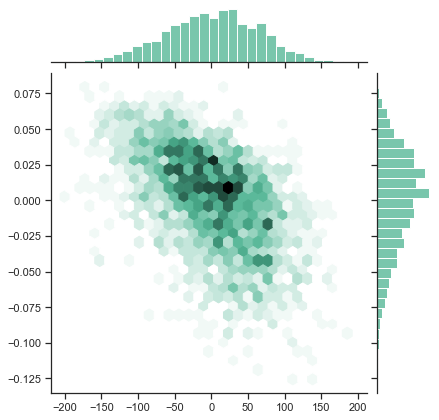

In [22]:
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")

x = Z200_region_re_de[JJA_index]
y = SM_region_re_de[JJA_index]

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")

# read shap and ML evaluation

In [23]:
shap_interaction_values = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe/Tmax_ver1.0/Simply_GradientBoosting_shap_interaction_values_run_mean_'+str(startyear)+'.npy',allow_pickle='True')

## the sum of the three parts would be the standardized Tx anomaly
y_pred = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe/Tmax_ver1.0/Simply_GradientBoosting_y_all_predict_run_mean_'+str(startyear)+'.npy',allow_pickle='True')
y_test = np.array(t2m_region_re_de_std[JJA_index])

## get back to unstandardized Tx anomaly
y_pred = y_pred*t2m_std1+t2m_ave1
y_test = y_test*t2m_std1+t2m_ave1

In [24]:
after_1979 = np.where(year_era5[JJA_index]>=1979)[0]

In [25]:
def quantile_loss(y_true, y_pred, alpha=0.9):
    diff = y_true - y_pred
    return np.mean(np.maximum(alpha * diff, (alpha - 1) * diff))

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance_score
# y_pred = model_c.predict(X_test)
# test_score = quantile_loss(y_test, y_pred, alpha=0.9)
print('mean_absolute_error:',  round(mean_absolute_error(y_test[after_1979], y_pred[after_1979 ]),2))
print('mean_squared_error:', round(mean_squared_error(y_test[after_1979 ], y_pred[after_1979 ]),2))
print('median_absolute_error:', round(median_absolute_error(y_test[after_1979 ], y_pred[after_1979 ]),2))
print('r2_score:', round(r2_score(y_test[after_1979 ], y_pred[after_1979 ]),2))
print('explained_variance_score:', round(explained_variance_score(y_test[after_1979 ], y_pred[after_1979 ]),2))
print('90th underestimation:',  round(np.nanpercentile(y_test[after_1979 ],90)- np.nanpercentile(y_pred[after_1979 ],90),2))
print('99th underestimation:',  round(np.nanpercentile(y_test[after_1979 ],99.5)- np.nanpercentile(y_pred[after_1979 ],99.5),2))
print('90th quantile loss:',quantile_loss(y_test[after_1979], y_pred[after_1979 ]))
print('99th quantile loss:',quantile_loss(y_test[after_1979], y_pred[after_1979 ],0.995))


mean_absolute_error: 1.03
mean_squared_error: 1.67
median_absolute_error: 0.88
r2_score: 0.78
explained_variance_score: 0.78
90th underestimation: 0.74
99th underestimation: 1.04
90th quantile loss: 0.5318115258036502
99th quantile loss: 0.5355023133010984


0.7717370445145535


Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


([<matplotlib.axis.YTick at 0x1a780d35748>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

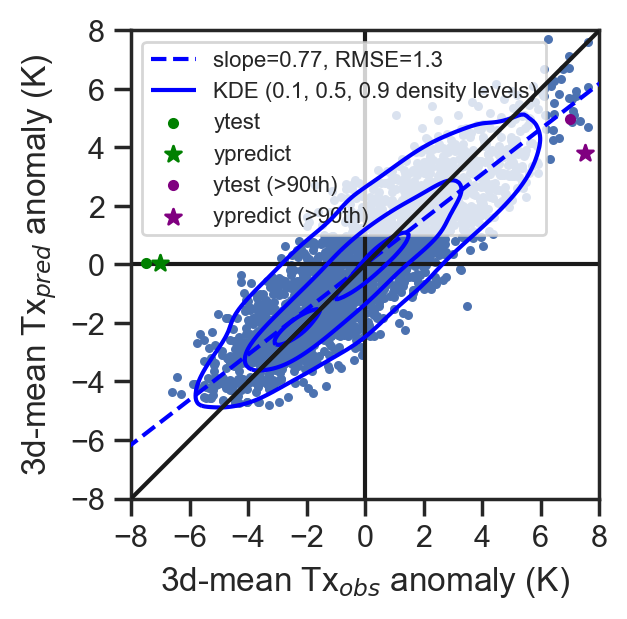

In [ ]:
xxx = y_test
yyy = y_pred


fig,ax = plt.subplots(figsize=(4.1,3.1),dpi=200,sharey='row',gridspec_kw={'wspace':0})

ax.plot([-4,4],[-4,4],c='k')
ax.axvline(0,c='k')
ax.axhline(0,c='k')


reg = LinearRegression().fit(xxx.reshape(-1, 1),yyy)
print(reg.score(xxx.reshape(-1, 1),yyy))
slope,int_,cor = scipy.stats.linregress(xxx,yyy)[:3]

mse_test = mean_squared_error(xxx,yyy)
rmse = np.sqrt(mse_test)

xx = np.arange(-10,10)
ax.plot(xx,slope*xx+int_,ls='--',label=f'slope={np.round(slope,2)}'+f', RMSE={np.round(rmse,1)}',zorder=501,color='blue')
sns.kdeplot(xxx,yyy ,ax=ax,levels=[.1,.5,.9],linewidths=1.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,label='KDE (0.1, 0.5, 0.9 density levels)',color='blue')
ax.scatter(xxx,yyy,s=5)
# hh = ax.hexbin(xxx,yyy, gridsize=50, cmap='PRGn_r', mincnt=1,zorder=200)
ax.plot([-10,10],[-10,10],zorder=501,color='k')
ax.scatter([-7.5],np.nanmean(xxx),marker='.',label='ytest',zorder=501,color='green')
ax.scatter([-7],np.nanmean(yyy),marker='*',label='ypredict',zorder=501,color='green')

ax.scatter([7],np.nanmean(xxx[xxx>np.nanpercentile(t2m_region_re_de[JJA_index],90)]),marker='.',label='ytest (>90th)',zorder=501,color='purple')
ax.scatter([7.5],np.nanmean(yyy[xxx>np.nanpercentile(t2m_region_re_de[JJA_index],90)]),marker='*',label='ypredict (>90th)',zorder=501,color='purple')
ax.set_xlabel ('3d-mean Tx$_{obs}$ anomaly (K)')
ax.set_ylabel ('3d-mean Tx$_{pred}$ anomaly (K)')
ax.set_aspect('equal')

ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend(fontsize=8)
plt.xticks(np.arange(-8,9,2))
plt.yticks(np.arange(-8,9,2))


Text(0.5, 0, 'Tx anomaly (K)')

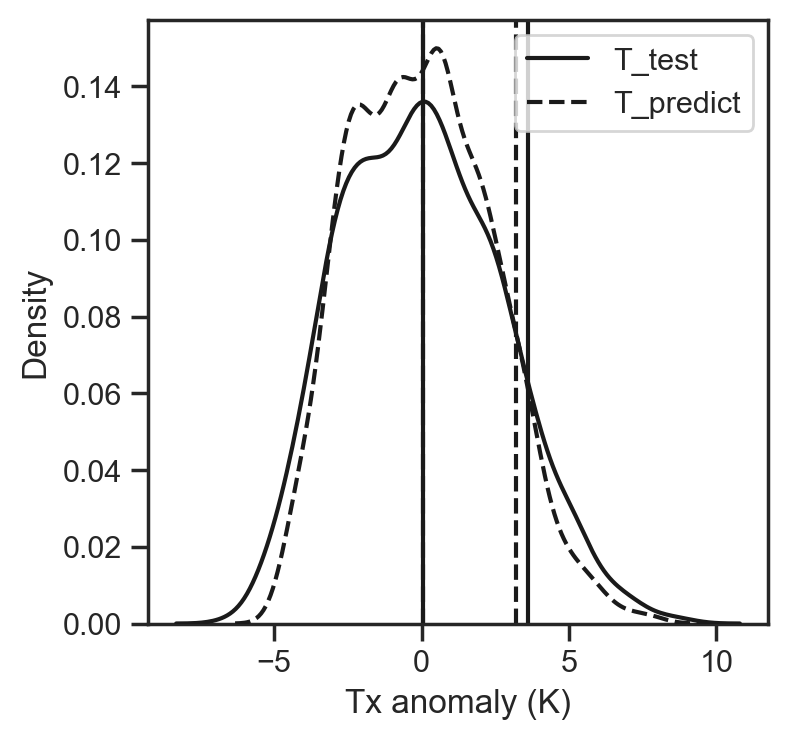

In [ ]:
fig = plt.figure(figsize=(4,4),dpi=200)
sns.kdeplot(y_test,levels=[.3],bw_adjust=1,zorder=400,color='k',label='T_test')
plt.axvline(np.nanmean(y_test),color='k')
plt.axvline(np.nanpercentile(y_test,90),color='k',linestyle='-')
sns.kdeplot(y_pred,levels=[.3],bw_adjust=1,zorder=400,color='k',label='T_predict',linestyle='--')
plt.axvline(np.nanmean(y_pred),color='k',linestyle='--')
plt.axvline(np.nanpercentile(y_pred,90),color='k',linestyle='--')
plt.legend()
plt.xlabel('Tx anomaly (K)')

# HW period, event, peak

In [27]:
import matplotlib.patches as patches

In [28]:
year_era5_all = year_era5
mon_era5_all = mon_era5
day_era5_all = day_era5
Z500_temp = Z200_region_re_de
SM_temp = SM_region_re_de
T_temp = t2m_region_re_de
b_temp1 = copy.deepcopy(shap_interaction_values[:,0,0])
b_temp2 = copy.deepcopy(shap_interaction_values[:,1,1])
b_temp0 = copy.deepcopy(2*shap_interaction_values[:,0,1])

# the sum of three decomposition is the standardized Tx anomaly
b_temp3 = b_temp0 +b_temp1+b_temp2

# translate standardized Tx anomaly back to unstandardized Tx anomaly for interpretation
b_temp4 = b_temp3*t2m_std1+t2m_ave1

In [ ]:
## define
import numpy as np
from scipy.signal import find_peaks

def find_first_negative(array):
    # Loop through each element in the array
    for index, value in enumerate(array):
        # Check if the current element is negative (reaching -0.5)
        if value <-0.5:
            return index  # Return the index and the negative value
    return len(array)  # Return None if no negative value is found



data =  t2m_region_re_de[JJA_index ]
y_data = year_era5_all[JJA_index]
mon_data = mon_era5_all[JJA_index]
day_data = day_era5_all[JJA_index]
data1 = data[data>np.percentile(data[y_data>=1979],90)]


## HW events
loc1 = np.where(data>np.percentile(data[y_data>=1979],90))[0]

## HW peaks
peaks, _ = find_peaks(data, height=0)
loc2 = peaks[np.isin(peaks, loc1)]

## HW periods
HW_flag = []
HW_flag_loc = []
HW_flag_peak = []
for i in loc2:
    # if (data[i-1]<np.percentile(data[y_data>=1979],90))&(data[i+1]<np.percentile(data[y_data>=1979],90)):
    #     continue
    ## find out initialization date i_i
    if (mon_data[i]==6)&(day_data[i]<=3):
        HW_flag.extend([i])
        HW_flag_loc.extend([0])
        continue
    elif (mon_data[i]==6)&(day_data[i]>3)&(day_data[i]<=6):
        jj=2
    elif (mon_data[i]==6)&(day_data[i]>6)&(day_data[i]<=9):
        jj=3
    elif (mon_data[i]==6)&(day_data[i]>9)&(day_data[i]<=12):
        jj=4
    else:
        jj=5
    array = data[i-jj:i+1]
    index = find_first_negative(array[::-1])
    # print(index)
    if index<=jj:
        i_i = index
    else:
        i_i = jj


    ## find out terminazition date i_e
    if (mon_data[i]==8)&(day_data[i]>=27):
        kk=1
    elif (mon_data[i]==8)&(day_data[i]>24)&(day_data[i]<=27):
        kk=2
    elif (mon_data[i]==8)&(day_data[i]>21)&(day_data[i]<=24):
        kk=3
    elif (mon_data[i]==8)&(day_data[i]>18)&(day_data[i]<=21):
        kk=4
    else:
        kk=5
    array = data[i:i+kk]
    index = find_first_negative(array)

    if index<=kk:
        i_e = index
    else:
        i_e = kk

    # if i_e+i_i-1<2:
        
    #     continue

    ## HW_period = i_i - i_e   
    HW_flag.extend(np.arange(i-i_i+1,i+i_e))
    HW_flag_loc.extend(np.arange(-i_i+1,i_e))
    HW_flag_peak.append(i)


HW_flag_new = []
HW_flag_loc_new = []
for i,j in zip(HW_flag,HW_flag_loc):
    if i in HW_flag_new:
        continue
    else:
        HW_flag_new.append(i)
        HW_flag_loc_new.append(j)
HW_flag =np.array(HW_flag_new)
HW_flag_loc =np.array(HW_flag_loc_new)


In [31]:
period_after1979 = HW_flag[year_era5_all[JJA_index][HW_flag]>=1979]
evenr_after1979 = loc1[year_era5_all[JJA_index][loc1]>=1979]
peak_afte1979 = loc2[year_era5_all[JJA_index][loc2]>=1979]

In [32]:
relative_contribution0 = copy.deepcopy(b_temp0/b_temp3)

T_abs_peak = t2m_region[JJA_index][peak_afte1979]
T_ano_peak = t2m_region_re_de[JJA_index][peak_afte1979]
top10_abs = peak_afte1979[np.argsort(T_abs_peak)[::-1][:10]]
top10_ano = peak_afte1979[np.argsort(T_ano_peak)[::-1][:10]]

In [33]:
data_length = len(SM_region[JJA_index ])
WEUdata_SHAP = pd.DataFrame()


WEUdata_SHAP ['year'] =  list(year_era5_all[JJA_index ])
WEUdata_SHAP ['month'] =  list(mon_era5_all[JJA_index ])
WEUdata_SHAP ['day'] =  list(day_era5_all[JJA_index ])



WEUdata_SHAP ['Z500_std'] =  Z200_region_re_de_std [JJA_index ]
WEUdata_SHAP ['SM_std'] =  SM_region_re_de_std[JJA_index ]
WEUdata_SHAP ['T_std'] =  t2m_region_re_de_std [JJA_index ]


WEUdata_SHAP ['Z500'] =  Z200_region_re_de [JJA_index ]
WEUdata_SHAP ['SM'] =  SM_region_re_de[JJA_index ]
WEUdata_SHAP ['T'] =  t2m_region_re_de [JJA_index ]
WEUdata_SHAP ['SHAP_Z_all'] =  b_temp1 
WEUdata_SHAP ['SHAP_SM_all'] =  b_temp2 


### decompose the unstandardized Tx anomaly based on the relative contribution detected by XML
WEUdata_SHAP ['SHAP_Z_independent'] = b_temp1 /b_temp3*b_temp4
WEUdata_SHAP ['SHAP_SM_independent'] =  b_temp2/b_temp3*b_temp4
WEUdata_SHAP ['SHAP_interact'] =  b_temp0/b_temp3*b_temp4

y_all_predic = y_pred
WEUdata_SHAP ['T_std_predict ']  = b_temp4
WEUdata_SHAP ['T_std_obs']  =  t2m_region_re_de[JJA_index]

dates = pd.date_range('1/1/1950', '31/12/2023', freq ='72H')
days = dates.day #Store all the days
months = dates.month #Store all the months
dates = dates[(~((days == 30) & (months == 12)))&(~((days ==31) & (months == 12)))][JJA_index ] 

WEUdata_SHAP.index = dates 

In [ ]:
maxnum = np.argsort( t2m_region_re_de[JJA_index] )[::-1][:30]


In [ ]:
# Evaluate fits
def evaluate_fit(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, mae

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])




# Decompostition analysis_2022 event (Fig. 1a-b)

In [39]:

event_index =20

maxnum = np.argsort( t2m_region_re_de[JJA_index] )[::-1][event_index]
print(year_era5_all[JJA_index][maxnum ])
print(mon_era5_all[JJA_index][maxnum ])
print(day_era5_all[JJA_index][maxnum ])
date_num = np.argsort( WEUdata_SHAP ['T'] )[::-1][event_index]
year_num = year_era5_all[JJA_index][date_num]
mon_num = mon_era5_all[JJA_index][date_num]
day_num = day_era5_all[JJA_index][date_num]

2022
7
19


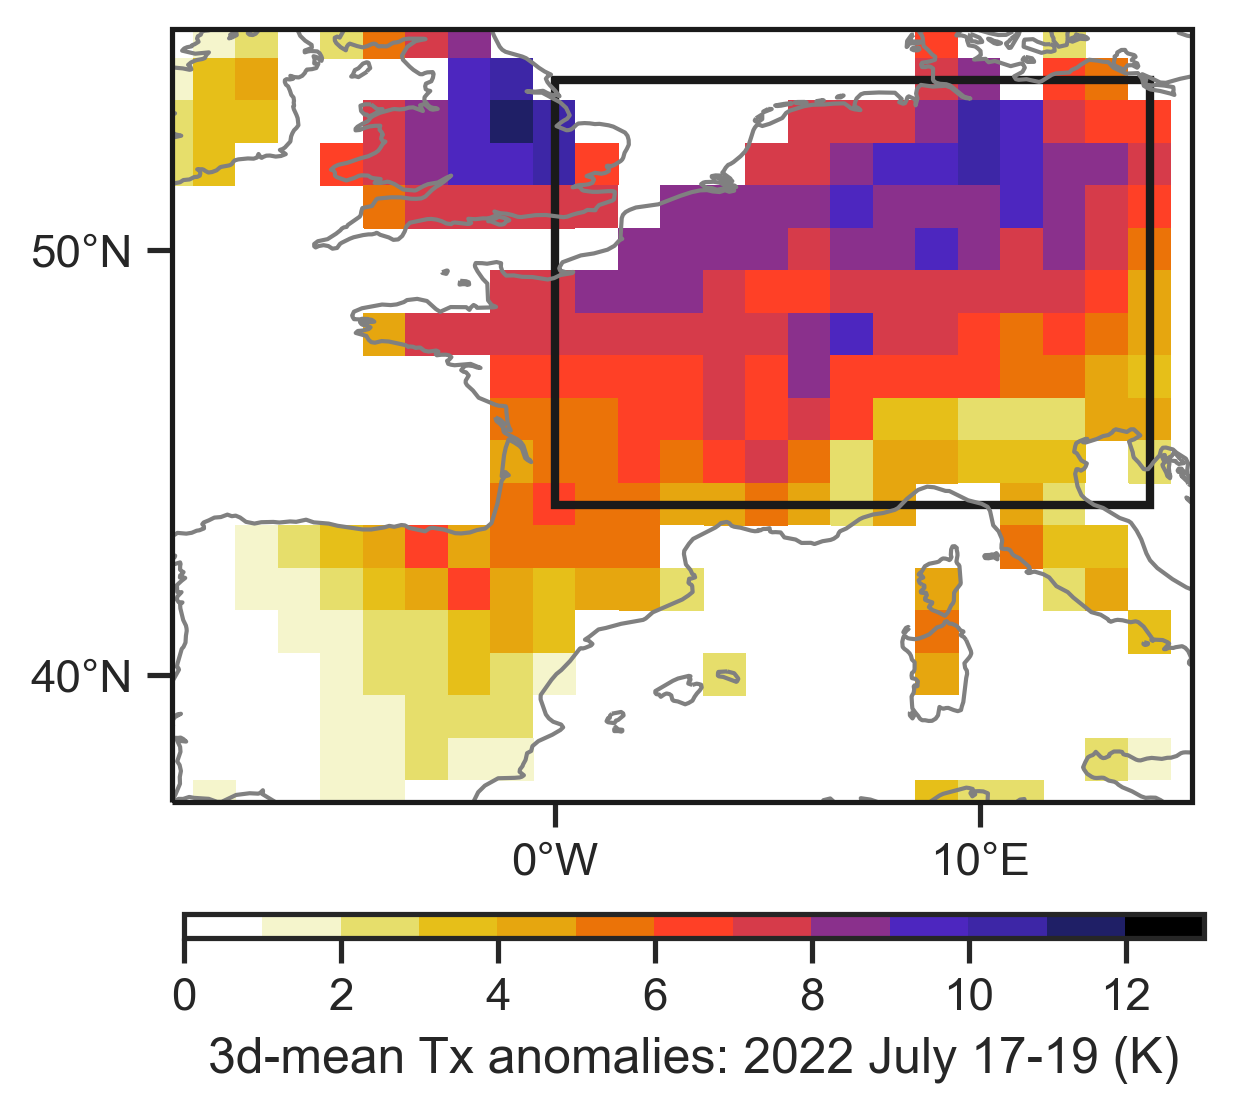

In [40]:

## Fig. 1a

cmap = cm.get_cmap('CMRmap_r',21)
fig= plt.figure(figsize=(4,4),dpi=300)
proj = ccrs.PlateCarree(central_longitude=0)##
ax = plt.axes([0.1, 0.2, 0.85, 0.77],projection = proj)
#ax.set_facecolor('#E8E8E8')
ax.set_facecolor('white')


levels = MaxNLocator(nbins=14).tick_values(0,13)

con_value = copy.deepcopy(t2m_large_re_de[np.in1d(mon_era5,[6,7,8])][date_num])
con_value[LAT_WEU<-60]=np.nan
con_value[land_mask<0.1]=np.nan

con_value1 = copy.deepcopy(land_mask*0)
con_value1[LAT_WEU<-60]=np.nan
con_value1[land_mask<0.1]=np.nan




con  = ax.contourf(LON_WEU,LAT_WEU,con_value1,colors='white')
norm = BoundaryNorm(levels, ncolors=21, clip=True)
#im = ax.contourf(LON_unin,LAT_unin, con_value, extend='both', cmap=cmap,levels=levels)
im = ax.pcolormesh(LON_WEU,LAT_WEU, con_value, cmap=cmap,norm=norm)
ax.coastlines(color='grey')

# ax.gridlines()
ax.set_xticks(np.arange(-180,190,10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,100,10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent([-9, 15, 37,55])
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.spines['geo'].set_color('k')

# rect1 = patches.Rectangle((-9, 37), 23, 18, linewidth=2, edgecolor='k', facecolor='none')
# ax.add_patch(rect1)


rect2 = patches.Rectangle((bnd_l, bnd_b),bnd_r-bnd_l,bnd_u-bnd_b, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect2)

ax.grid(linestyle='--')
cax = plt.axes([0.11, 0.15, 0.85, 0.02])
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
#ax1.grid(b=False)

cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
# cbar.set_label('T2m anomalies: '+str(year_num)+'.' +str(mon_num) + '.' +str(day_num-3)+'-' +str(day_num-1)+' (K)')
cbar.set_label('3d-mean Tx anomalies: 2022 July 17-19 (K)')
# cax.set_xticks(np.arange(-1,1.1,0.1))
# cax.set_xticklabels(np.arange(-1,1.1,0.1))
#fig.savefig(output_path+'figure/'+senarioname+'/'+modelname+'PV_ND_90TH_'+str(yearstart)+'_'+str(yearend)+'_delta.jpg', dpi=300)
# fig.savefig(out_folder+'2003event_T2m_map.jpg',bbox_inches='tight',dpi=300)


In [46]:

step_forward = 7
step_after =6


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


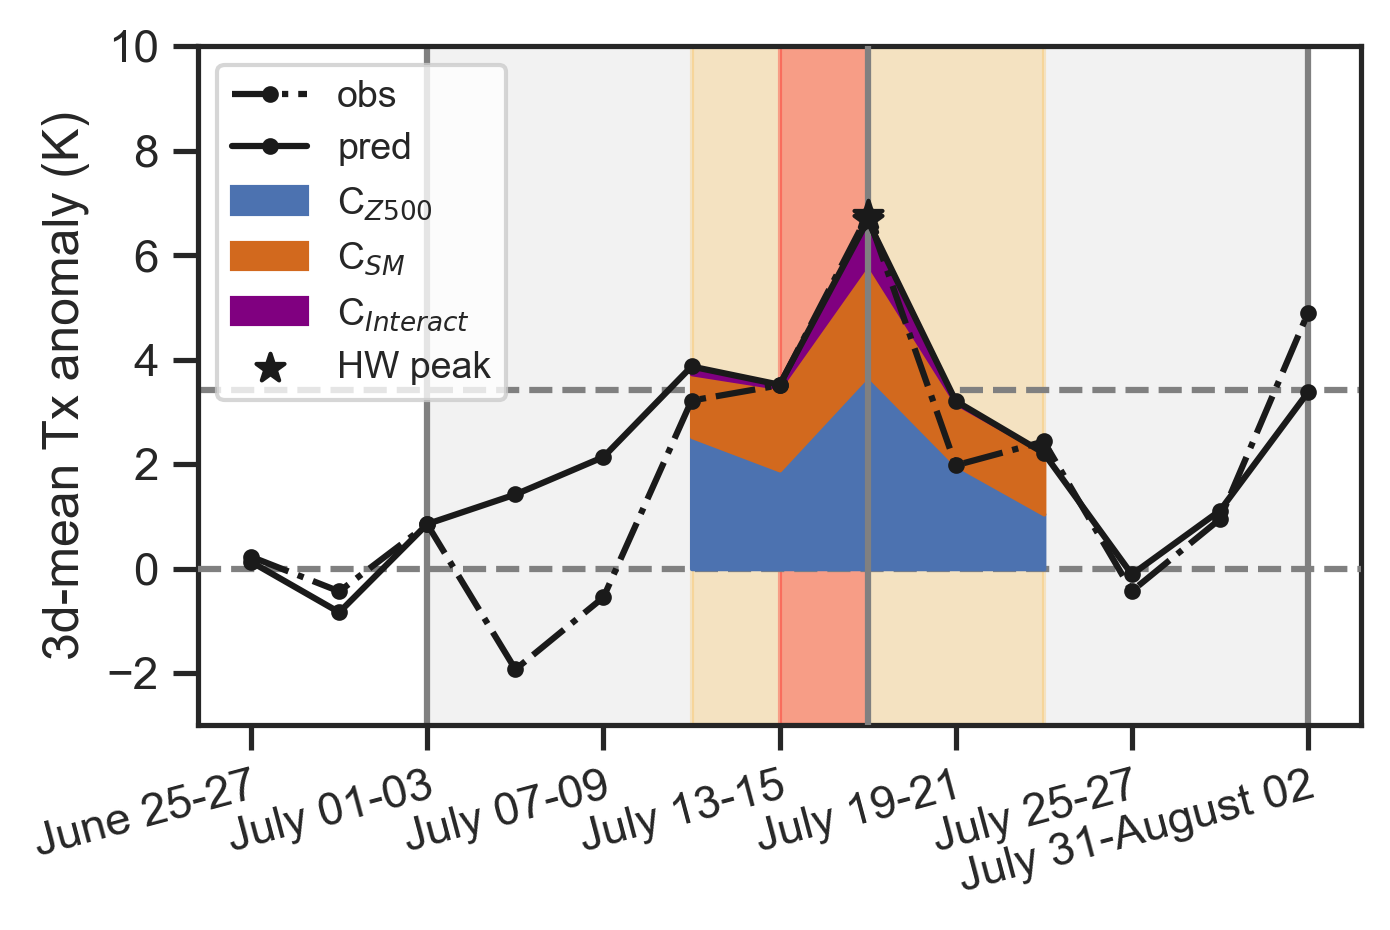

In [ ]:
fig = plt.figure(figsize=(5,3),dpi=300)
ax = plt.axes()

zz1 = copy.deepcopy((WEUdata_SHAP ['SHAP_Z_independent']))
zz2 = copy.deepcopy((WEUdata_SHAP ['SHAP_Z_independent']+ WEUdata_SHAP ['SHAP_SM_independent']))
zz3 = copy.deepcopy((WEUdata_SHAP ['SHAP_Z_independent']+ WEUdata_SHAP ['SHAP_SM_independent']+WEUdata_SHAP ['SHAP_interact']))


WEUdata_SHAP ['T_std_predict '][date_num] = zz3[date_num]

ax.fill_between(dates[date_num-step_forward+5 :date_num+step_after-3],0*zz1[date_num-step_forward+5 :date_num+step_after-3],zz1[date_num-step_forward+5 :date_num+step_after-3],label='C$_{Z500}$',color='b',zorder=200)
ax.fill_between(dates[date_num-step_forward+5 :date_num+step_after-3],zz1[date_num-step_forward+5 :date_num+step_after-3],zz2[date_num-step_forward+5 :date_num+step_after-3],label='C$_{SM}$',color='chocolate',zorder=200)
ax.fill_between(dates[date_num-step_forward+5 :date_num+step_after-3], zz2[date_num-step_forward+5 :date_num+step_after-3],zz3[date_num-step_forward+5 :date_num+step_after-3],label='C$_{Interact}$',color='purple',zorder=200)

ax.plot(dates[date_num-step_forward :date_num+step_after],WEUdata_SHAP ['T_std_obs'][date_num-step_forward :date_num+step_after],label='obs',c='k',linestyle='-.',marker='.',zorder=400)
ax.plot(dates[date_num-step_forward :date_num+step_after], WEUdata_SHAP ['T_std_predict '][date_num-step_forward :date_num+step_after],label='pred',c='k',linestyle='-',marker='.',zorder=400)
ax.scatter(dates[date_num],WEUdata_SHAP ['T_std_obs'][date_num],c='k',marker='*', s=50,label='HW peak',zorder=400)
ax.scatter(dates[date_num], WEUdata_SHAP ['T_std_predict '][date_num],c='k',marker='*', s=50,zorder=400)


ax.axvline(dates[date_num],c='grey',linestyle='-',zorder=300)
ax.axvline(dates[date_num-5],c='grey',linestyle='-')
ax.axvline(dates[date_num+5],c='grey',linestyle='-')
ax.axvspan(xmin=dates[date_num-5],xmax=dates[date_num+5],color='grey',alpha=0.1)
ax.axvspan(xmin=dates[date_num-2],xmax=dates[date_num+2],color='orange',alpha=0.2)
ax.axvspan(xmin=dates[date_num-1],xmax=dates[date_num],color='red',alpha=0.3)

ax.axhline(np.nanpercentile(WEUdata_SHAP ['T_std_obs'],90),c='grey',linestyle='--')
ax.axhline(0,c='grey',linestyle='--',zorder=100)
plt.xticks(rotation=15, ha='right', rotation_mode='anchor')

ax.set_ylim(-3,10)
plt.xticks(dates[date_num-step_forward :date_num+step_after][::2],['June 25-27','July 01-03','July 07-09','July 13-15','July 19-21','July 25-27','July 31-August 02'])

ax.set_ylabel('3d-mean Tx anomaly (K)')
plt.legend(fontsize=9)


# Nonlienar analysis_main (Fig. 1c-e)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
l_color = '#298c8c'
p_color = '#800074'

In [ ]:
def piecewise_linear_sig(xx, x0, y0,yearyear):
    # Number of bootstrap samples
    n_bootstraps = 100

    # Container to hold the bootstrap slope estimates
    bootstrap_cp = []
    bootstrap_s2 = []
    bootstrap_y_linear = []
    bootstrap_y_piece = []
    bootstrap_dr2 = []
    bootstrap_dAIC = []
    bootstrap_r2_l = []
    bootstrap_r2_p = []
    bootstrap_s = []

    for ii in range(n_bootstraps):

        for i_year in range(1979,2024):


            bootstrap_sample = np.copy(range(len(x0)))
            indices_to_replace = np.where(yearyear==i_year)[0]
            indices_rest = [i for i in np.arange(len(x0)) if i not in indices_to_replace]
            bootstrap_sample[indices_to_replace] = np.random.choice(indices_rest, size=len(indices_to_replace), replace=False)
        

            indices = bootstrap_sample
            xxx = x0[indices]
            yyy = y0[indices]
            
            try:
                params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
            except RuntimeError as e:
                continue
            y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
            y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
            r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
            slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
            y_pred_l = slope*xxx+int
            y_pred_l1 = slope*xx+int

            r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
            dr2 = r2_piecewise-r2_l

            aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
            aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
            

            DAIC = aic_segmented-aic_l

            bootstrap_cp.append(params_piecewise[0])
            bootstrap_s2.append(params_piecewise[3])
            bootstrap_y_linear.append(y_pred_l1)
            bootstrap_y_piece.append(y_pred_piecewise1)
            bootstrap_dr2.append(dr2)
            bootstrap_dAIC.append(DAIC)
            bootstrap_r2_l.append(r2_l)
            bootstrap_r2_p.append(r2_piecewise)
            bootstrap_s.append(slope)

    return np.array(bootstrap_cp),np.array(bootstrap_s2),np.array(bootstrap_y_linear),np.array(bootstrap_y_piece),np.array(bootstrap_dr2),np.array(bootstrap_dAIC),np.array(bootstrap_r2_l),np.array(bootstrap_r2_p),np.array(bootstrap_s)

In [ ]:
def piecewise_linear_sig_quantile(xx, x0, y0,yearyear):


    # Number of bootstrap samples
    n_bootstraps = 100

    # Container to hold the bootstrap slope estimates
    bootstrap_cp = []
    bootstrap_s2 = []
    bootstrap_y_linear = []
    bootstrap_y_piece = []
    bootstrap_dr2 = []
    bootstrap_dAIC = []
    bootstrap_r2_l = []
    bootstrap_r2_p = []
    bootstrap_s = []

    for ii in range(n_bootstraps):
    #     # for i in range(n_bootstraps):
        for i_year in range(1979,2024):


            bootstrap_sample = np.copy(range(len(x0)))

            # Resample with replacement of i_year
            indices_to_replace = np.where(yearyear==i_year)[0]
            indices_rest = [i for i in np.arange(len(x0)) if i not in indices_to_replace]

            # Replace the selected indices with new values from the rest data
            bootstrap_sample[indices_to_replace] = np.random.choice(indices_rest, size=len(indices_to_replace), replace=False)
        

            indices = bootstrap_sample
            xxx = x0[indices]
            yyy = y0[indices]
            
            xx_temp_median = np.arange(np.nanmin(xx),np.nanmax(xx)+0.5,0.5)
            yy_temp_median = []
            yy_temp_90 = []
            yy_temp_10 = []
            yy_temp_all = []
            for i_x in  xx_temp_median:
                temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
                yy_temp_median.append(np.nanpercentile(temp,50))
                yy_temp_90.append(np.nanpercentile(temp,90))
                yy_temp_10.append(np.nanpercentile(temp,10))
                yy_temp_all.append(temp)

            xxx = copy.deepcopy(np.array(xx_temp_median))
            yyy = copy.deepcopy(np.array(yy_temp_median))
            nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
            xxx = xxx[nan_index]
            yyy = yyy[nan_index]

            try:
                params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
            except RuntimeError as e:
                continue
            y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
            y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
            r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
            slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
            y_pred_l = slope*xxx+int
            y_pred_l1 = slope*xx+int

            r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
            dr2 = r2_piecewise-r2_l

            aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
            aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
            
            DAIC = aic_segmented-aic_l
 
            bootstrap_cp.append(params_piecewise[0])
            bootstrap_s2.append(params_piecewise[3])
            bootstrap_y_linear.append(y_pred_l1)
            bootstrap_y_piece.append(y_pred_piecewise1)
            bootstrap_dr2.append(dr2)
            bootstrap_dAIC.append(DAIC)
            bootstrap_r2_l.append(r2_l)
            bootstrap_r2_p.append(r2_piecewise)
            bootstrap_s.append(slope)

    return np.array(bootstrap_cp),np.array(bootstrap_s2),np.array(bootstrap_y_linear),np.array(bootstrap_y_piece),np.array(bootstrap_dr2),np.array(bootstrap_dAIC),np.array(bootstrap_r2_l),np.array(bootstrap_r2_p),np.array(bootstrap_s)

In [ ]:
basevalue1 = np.nanmean(t2m_region[JJA_index])
basevalue1_0 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=2023)&(year_era5_all[JJA_index]>=1979)])
basevalue1_1 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=1999)&(year_era5_all[JJA_index]>=1979)])
basevalue1_2 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=2023)&(year_era5_all[JJA_index]>=2003)])

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice

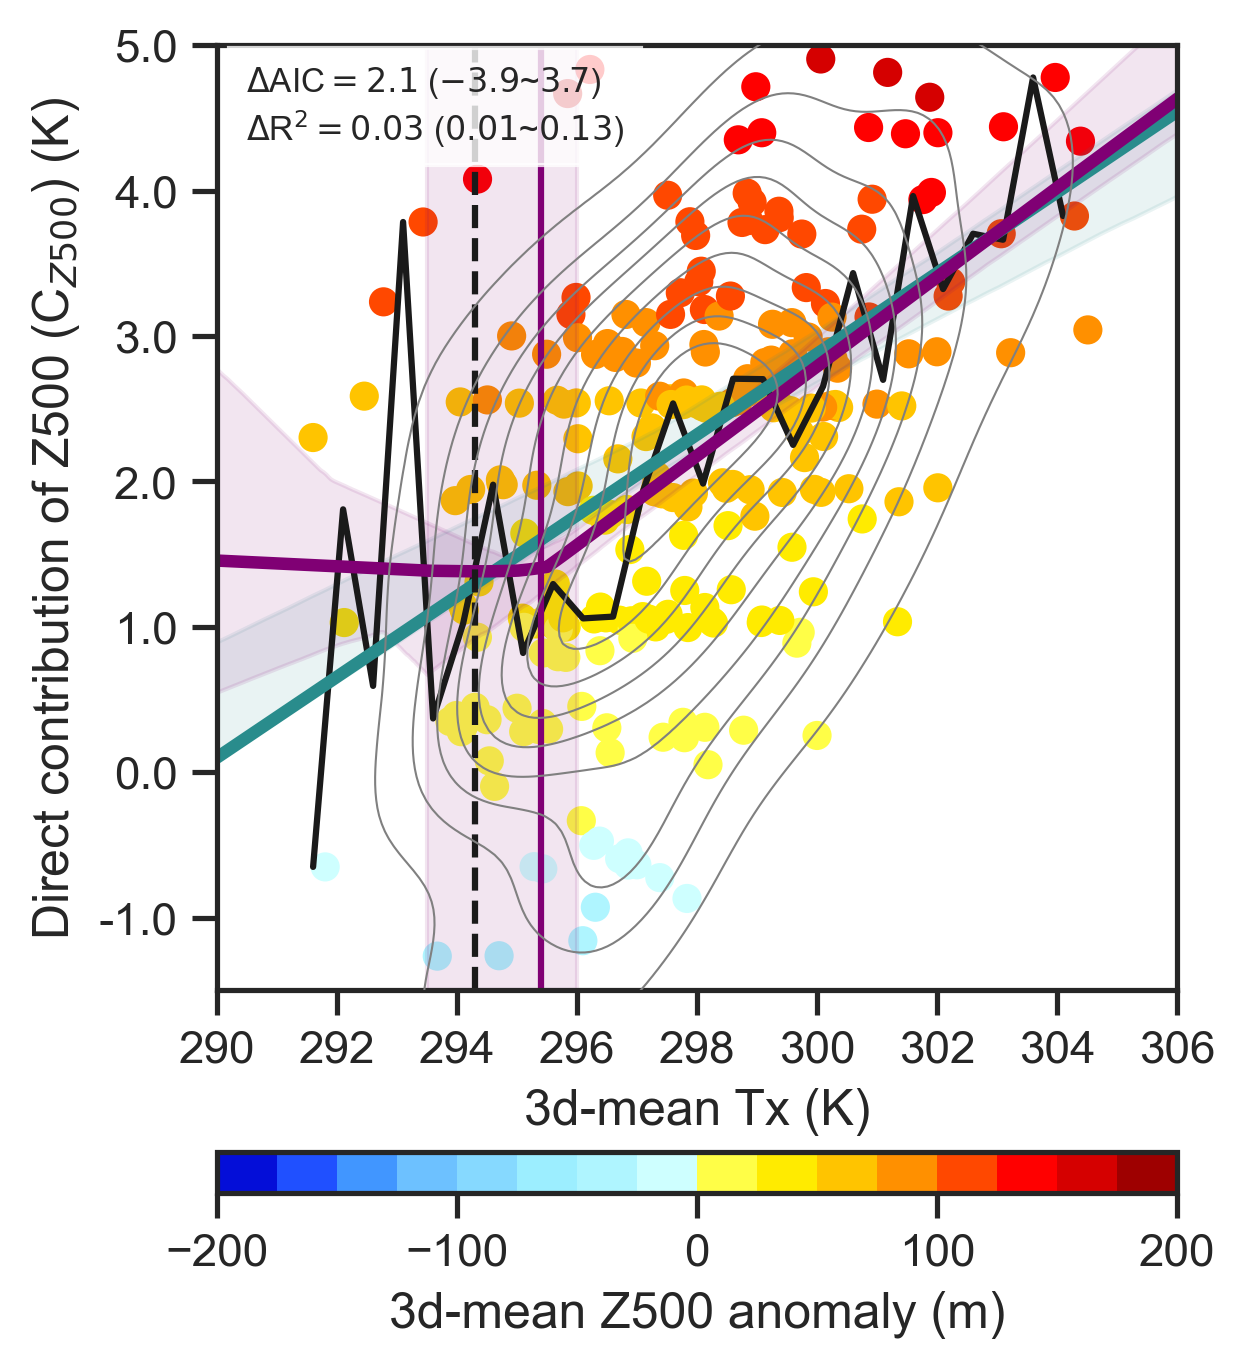

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = Z200_region_re_de[JJA_index][HW_flag]
x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = b_temp1[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]
index_where = np.where((y<=2023)&(y>=1979))[0]

fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis


im = ax1.scatter(x[index_where],z[index_where],c= x1[index_where],cmap=cmaps.GMT_panoply,vmin=-200,vmax=200)
ax1.set_ylabel('Direct contribution of Z500 (C$_{Z500}$) (K)')

cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label='3d-mean Z500 anomaly (m)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_ylim(-1.5,5)
ax1.set_yticks(np.arange(-1,6,1))
ax1.set_yticklabels(np.arange(-1,6,1))


xx = np.arange(14,35,0.01)*1.0+272

xxx = x[index_where]
yyy = z[index_where]
yearyear = y[index_where]
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
yearyear = y[nan_index]
sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=0.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)

bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig_quantile(xx, xxx,yyy,yearyear)





xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)


ax1.plot(xx_temp_median,yy_temp_median,c='k')
xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]


params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l


ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, np.nanmean(bootstrap_y_piece,axis=0), label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)
ax1.axvline(np.nanmean(bootstrap_cp),color=p_color,linestyle = '-',label=r'$T_{c}$')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)

ax1.axvline(basevalue1_0,color='k',linestyle = '--',label=r'$T_{mean}$')


xx_new = np.arange(290,307)
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)




Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


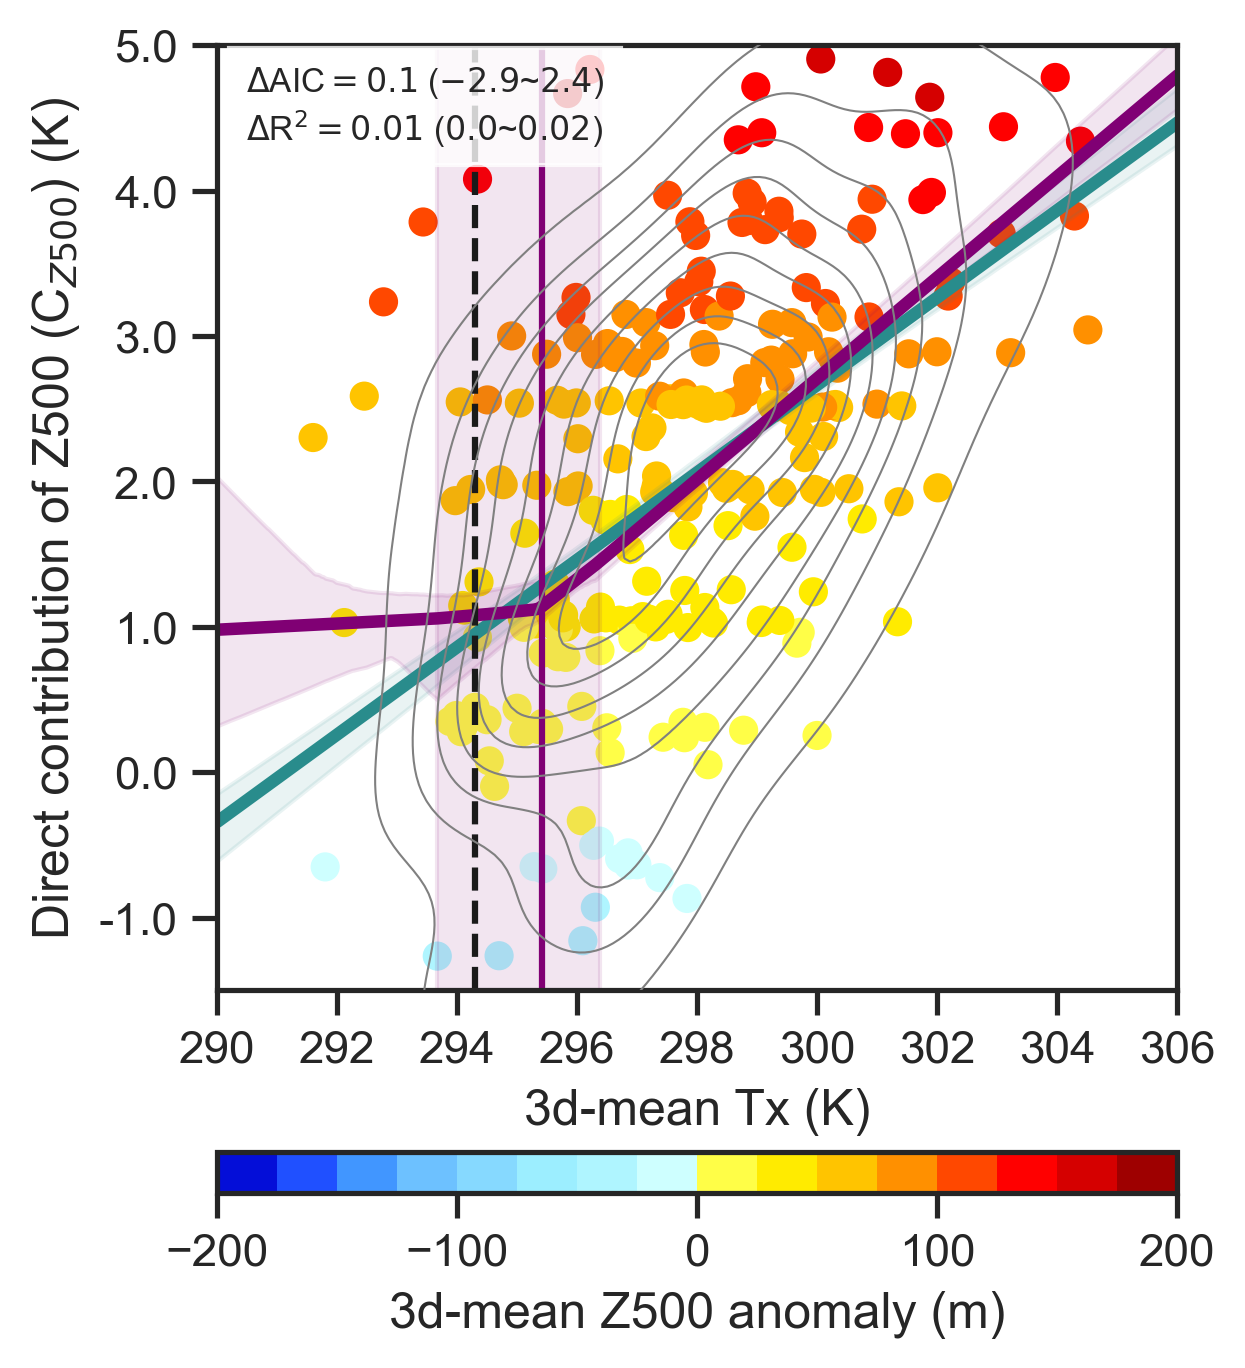

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = Z200_region_re_de[JJA_index][HW_flag]
x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = b_temp1[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]
index_where = np.where((y<=2023)&(y>=1979))[0]

fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis


im = ax1.scatter(x[index_where],z[index_where],c= x1[index_where],cmap=cmaps.GMT_panoply,vmin=-200,vmax=200)
ax1.set_ylabel('Direct contribution of Z500 (C$_{Z500}$) (K)')

cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label='3d-mean Z500 anomaly (m)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_ylim(-1.5,5)
ax1.set_yticks(np.arange(-1,6,1))
ax1.set_yticklabels(np.arange(-1,6,1))


xx = np.arange(14,35,0.01)*1.0+272

xxx = x[index_where]
yyy = z[index_where]
yearyear = y[index_where]
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
yearyear = y[nan_index]
sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=0.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)

bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig(xx, xxx,yyy,yearyear)



nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]


params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l


ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, np.nanmean(bootstrap_y_piece,axis=0), label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)
ax1.axvline(np.nanmean(bootstrap_cp),color=p_color,linestyle = '-',label=r'$T_{c}$')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)


ax1.axvline(basevalue1_0,color='k',linestyle = '--',label=r'$T_{mean}$')




xx_new = np.arange(290,307)
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)




Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice

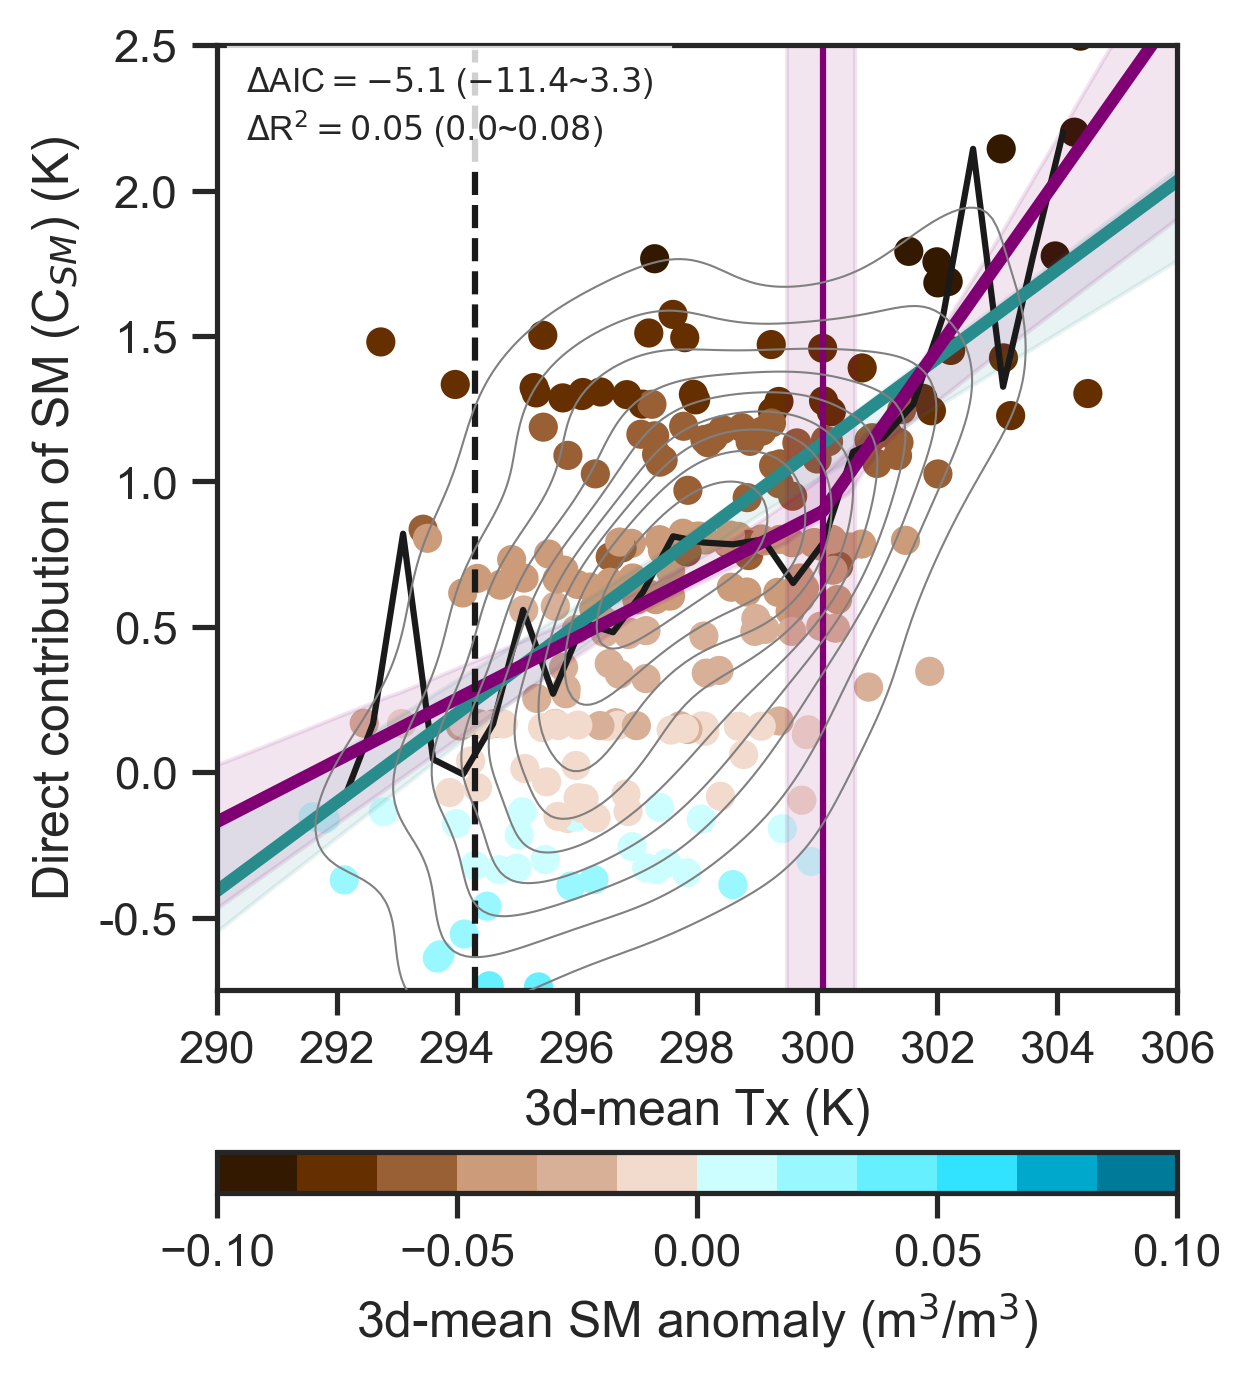

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = SM_region_re_de[JJA_index][HW_flag]
x = t2m_region[JJA_index][HW_flag]



y = year_era5_all[JJA_index][HW_flag]
z = b_temp2[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]

index_where = np.where((y<=2023)&(y>=1979))[0]
fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis

im = ax1.scatter(x[index_where],z[index_where],c=x1[index_where],cmap=cmaps.BrownBlue12,vmin=-0.1,vmax=0.1)

ax1.set_ylabel('Direct contribution of SM (C$_{SM}$) (K)')

cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label='3d-mean SM anomaly (m$^3$/m$^3$)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_yticks(np.arange(-1,3,0.5))
ax1.set_yticklabels(np.arange(-1,3,0.5))
ax1.set_ylim(-0.75,2.5)
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])


xx = np.arange(14,35,0.01)*1.0+272

xxx = x[index_where]
yyy = z[index_where]
yearyear = y[index_where]
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
yearyear = y[nan_index]
sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=0.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)

bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig_quantile(xx, xxx,yyy,yearyear)



xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)


ax1.plot(xx_temp_median,yy_temp_median,c='k')
xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]


params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l



ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, y_pred_piecewise1, label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)
ax1.axvline(params_piecewise[0],color=p_color,linestyle = '-',label=r'$T_{c}$')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)


ax1.axvline(basevalue1_0,color='k',linestyle = '--',label=r'$T_{mean}$')




xx_new = np.arange(290,307)
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)




Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


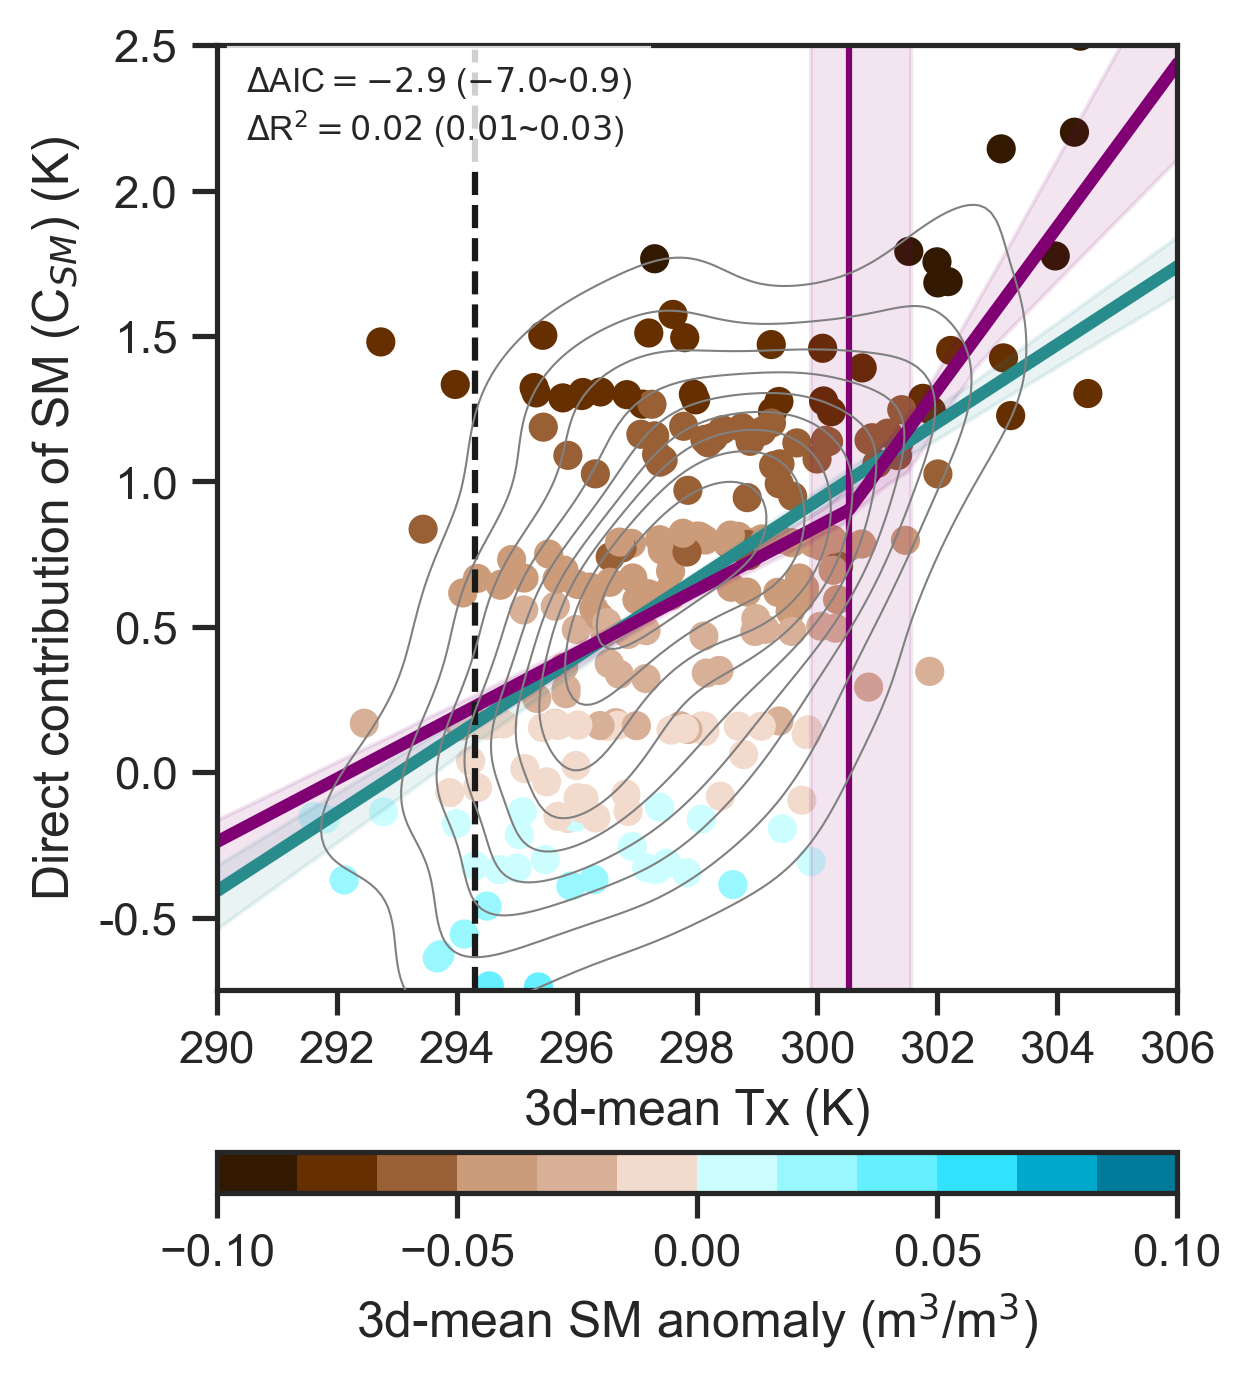

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = SM_region_re_de[JJA_index][HW_flag]
x = t2m_region[JJA_index][HW_flag]



y = year_era5_all[JJA_index][HW_flag]
z = b_temp2[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]

index_where = np.where((y<=2023)&(y>=1979))[0]
fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis

im = ax1.scatter(x[index_where],z[index_where],c=x1[index_where],cmap=cmaps.BrownBlue12,vmin=-0.1,vmax=0.1)

ax1.set_ylabel('Direct contribution of SM (C$_{SM}$) (K)')

cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label='3d-mean SM anomaly (m$^3$/m$^3$)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_yticks(np.arange(-1,3,0.5))
ax1.set_yticklabels(np.arange(-1,3,0.5))
ax1.set_ylim(-0.75,2.5)
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])


xx = np.arange(14,35,0.01)*1.0+272

xxx = x[index_where]
yyy = z[index_where]
yearyear = y[index_where]
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
yearyear = y[nan_index]
sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=0.5,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)

bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig(xx, xxx,yyy,yearyear)


nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]


params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l



ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, y_pred_piecewise1, label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)
ax1.axvline(params_piecewise[0],color=p_color,linestyle = '-',label=r'$T_{c}$')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)


ax1.axvline(basevalue1_0,color='k',linestyle = '--',label=r'$T_{mean}$')




xx_new = np.arange(290,307)
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)




Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


1979~2023


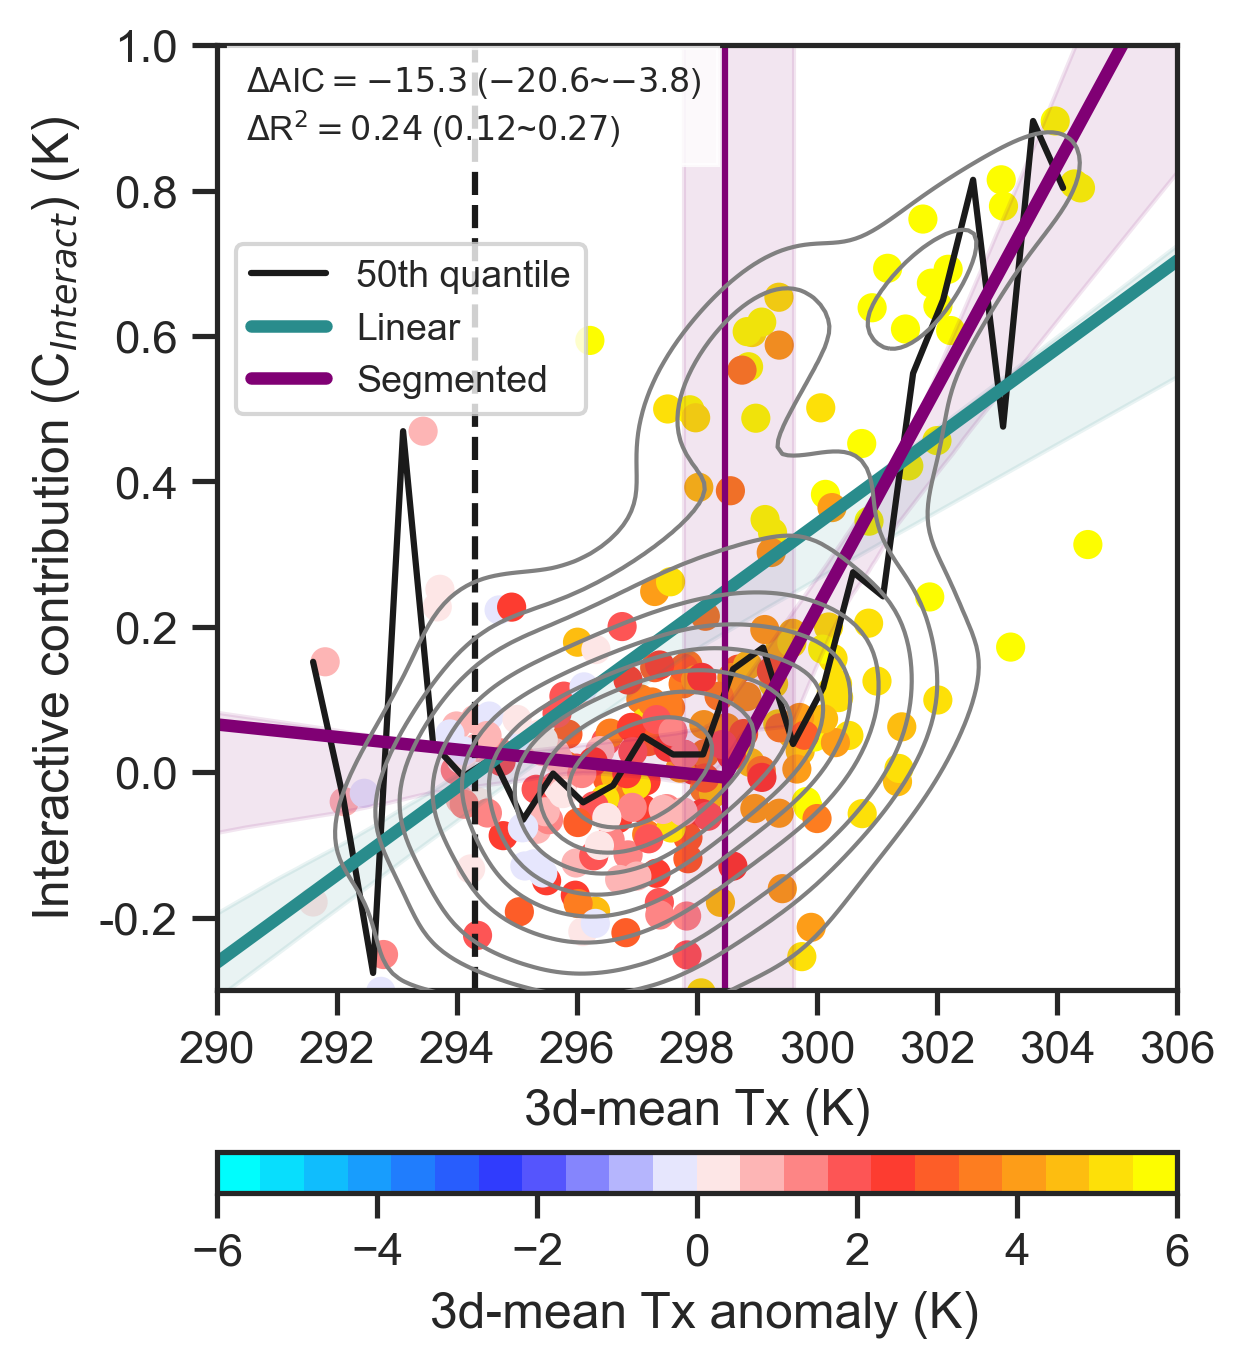

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = t2m_region_re_de[JJA_index][HW_flag]
x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = b_temp0[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]

index_where = np.where((y<=2023)&(y>=1979))[0]
xxx = x[index_where]
yyy = z[index_where]
ccc = x1[index_where]
yearyear = y[index_where]

nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
ccc = ccc[nan_index]
yearyear = y[nan_index]
bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig_quantile(xx, xxx,yyy,yearyear)



#################
xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)


fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis

im = ax1.scatter(xxx,yyy,c= ccc,cmap=cmaps.cmp_flux,vmin=-6,vmax=6)
ax1.set_ylabel('Interactive contribution (C$_{Interact}$) (K)')
cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label=' 3d-mean Tx anomaly (K)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


plt.subplots_adjust(left=0.2)
# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_ylim(-0.3,1)



sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=1,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)
ax1.axvline(basevalue1_0,color='k',linestyle = '--')


ax1.plot(xx_temp_median,yy_temp_median,c='k',label='50th quantile')
xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
########fitting
xx = np.arange(14,35,0.01)*1.0+272

params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l



ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, y_pred_piecewise1, label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)

ax1.axvline(params_piecewise[0],color=p_color,linestyle = '-')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)


xx_new = np.arange(290,307)
ax1.legend(fontsize=9,loc='center left',bbox_to_anchor=(0.0, 0.7))
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)
print('1979~2023')


Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


1979~2023


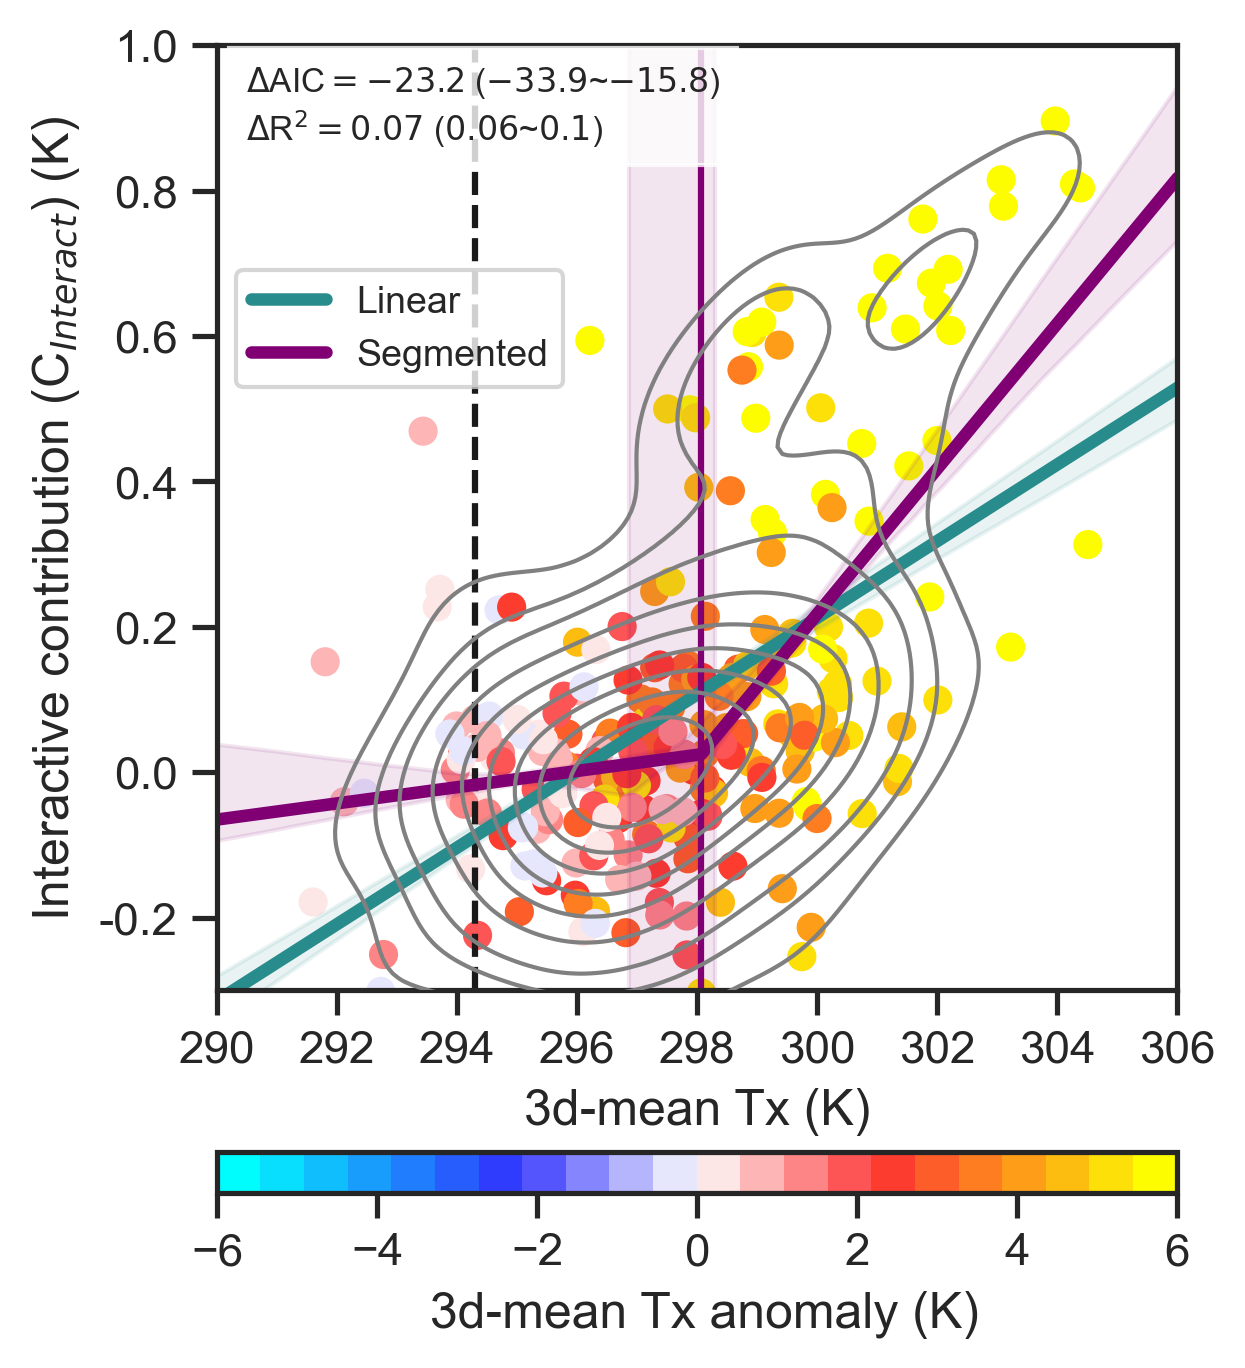

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])
# def piecewise_linear(x, x0, y0, k1, k2):
#     return np.piecewise(x, [x < x0], [lambda x: 0, lambda x: k2*x + 0-k2*x0])
x1 = t2m_region_re_de[JJA_index][HW_flag]
x = t2m_region[JJA_index][HW_flag]
# x = T_temp[JJA_index]
y = year_era5_all[JJA_index][HW_flag]
z = b_temp0[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]

index_where = np.where((y<=2023)&(y>=1979))[0]
xxx = x[index_where]
yyy = z[index_where]
ccc = x1[index_where]
yearyear = y[index_where]

nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
ccc = ccc[nan_index]
yearyear = y[nan_index]
bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig(xx, xxx,yyy,yearyear)

fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis




im = ax1.scatter(xxx,yyy,c= ccc,cmap=cmaps.cmp_flux,vmin=-6,vmax=6)
ax1.set_ylabel('Interactive contribution (C$_{Interact}$) (K)')
cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label=' 3d-mean Tx anomaly (K)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


plt.subplots_adjust(left=0.2)
# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_ylim(-0.3,1)



sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=1,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)
ax1.axvline(basevalue1_0,color='k',linestyle = '--')


########fitting
xx = np.arange(14,35,0.01)*1.0+272

params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l



ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, y_pred_piecewise1, label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)

ax1.axvline(params_piecewise[0],color=p_color,linestyle = '-')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)


xx_new = np.arange(290,307)
ax1.legend(fontsize=9,loc='center left',bbox_to_anchor=(0.0, 0.7))
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)
print('1979~2023')


# Nonlinear_interpretation 

Mean of empty slice
Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


1979~2023


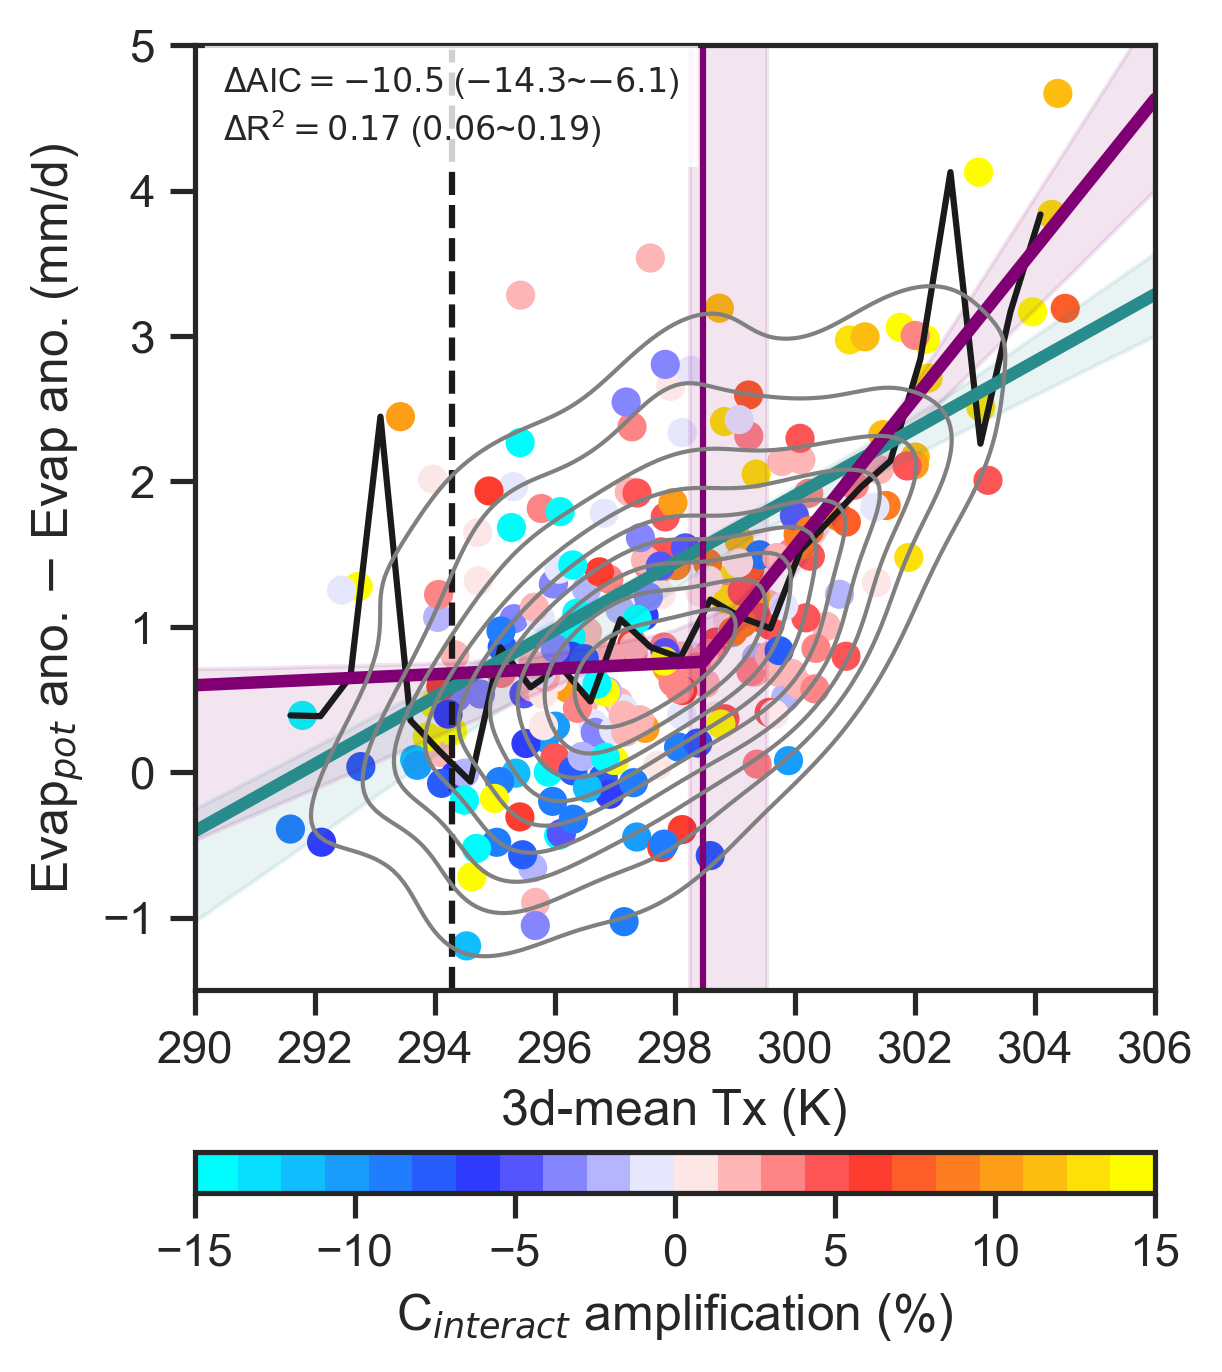

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = b_temp0[HW_flag]/(b_temp1[HW_flag]+b_temp2[HW_flag])*100
x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = evap_pet_region_re_de[JJA_index][HW_flag]*1000-evap_region_re_de[JJA_index][HW_flag]*1000

index_where = np.where((y<=2023)&(y>=1979))[0]
xxx = x[index_where]
yyy = z[index_where]
ccc = x1[index_where]
yearyear = y[index_where]

nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
ccc = ccc[nan_index]
yearyear = y[nan_index]
bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig_quantile(xx, xxx,yyy,yearyear)



#################
xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)


fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis

im = ax1.scatter(xxx,yyy,c= ccc,cmap=cmaps.cmp_flux,vmin=-15,vmax=15)
ax1.set_ylabel('Evap$_{pot}$ ano. $-$ Evap ano. (mm/d)')
cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 

cax = fig.colorbar(im,label=r'C$_{interact}$ amplification (%)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


plt.subplots_adjust(left=0.2)
# ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_ylim(-1.5,5)



sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=1,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)
ax1.axvline(basevalue1_0,color='k',linestyle = '--')


ax1.plot(xx_temp_median,yy_temp_median,c='k',label='50th quantile')
xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
########fitting
xx = np.arange(14,35,0.01)*1.0+272

params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l



ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_linear,0.5,axis=0),np.nanpercentile(bootstrap_y_linear,99.5,axis=0),alpha=0.1,color=l_color)
ax1.plot(xx, y_pred_piecewise1, label='Segmented',linestyle='-',c=p_color,linewidth=3)

ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color=p_color)

ax1.axvline(params_piecewise[0],color=p_color,linestyle = '-',label=r'$T_{c}$')
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color=p_color,alpha=0.1)


xx_new = np.arange(290,307)
# ax1.legend(fontsize=9,loc='center left',bbox_to_anchor=(0.0, 0.7))
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
# ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)
print('1979~2023')

Mean of empty slice
Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


1979~2023


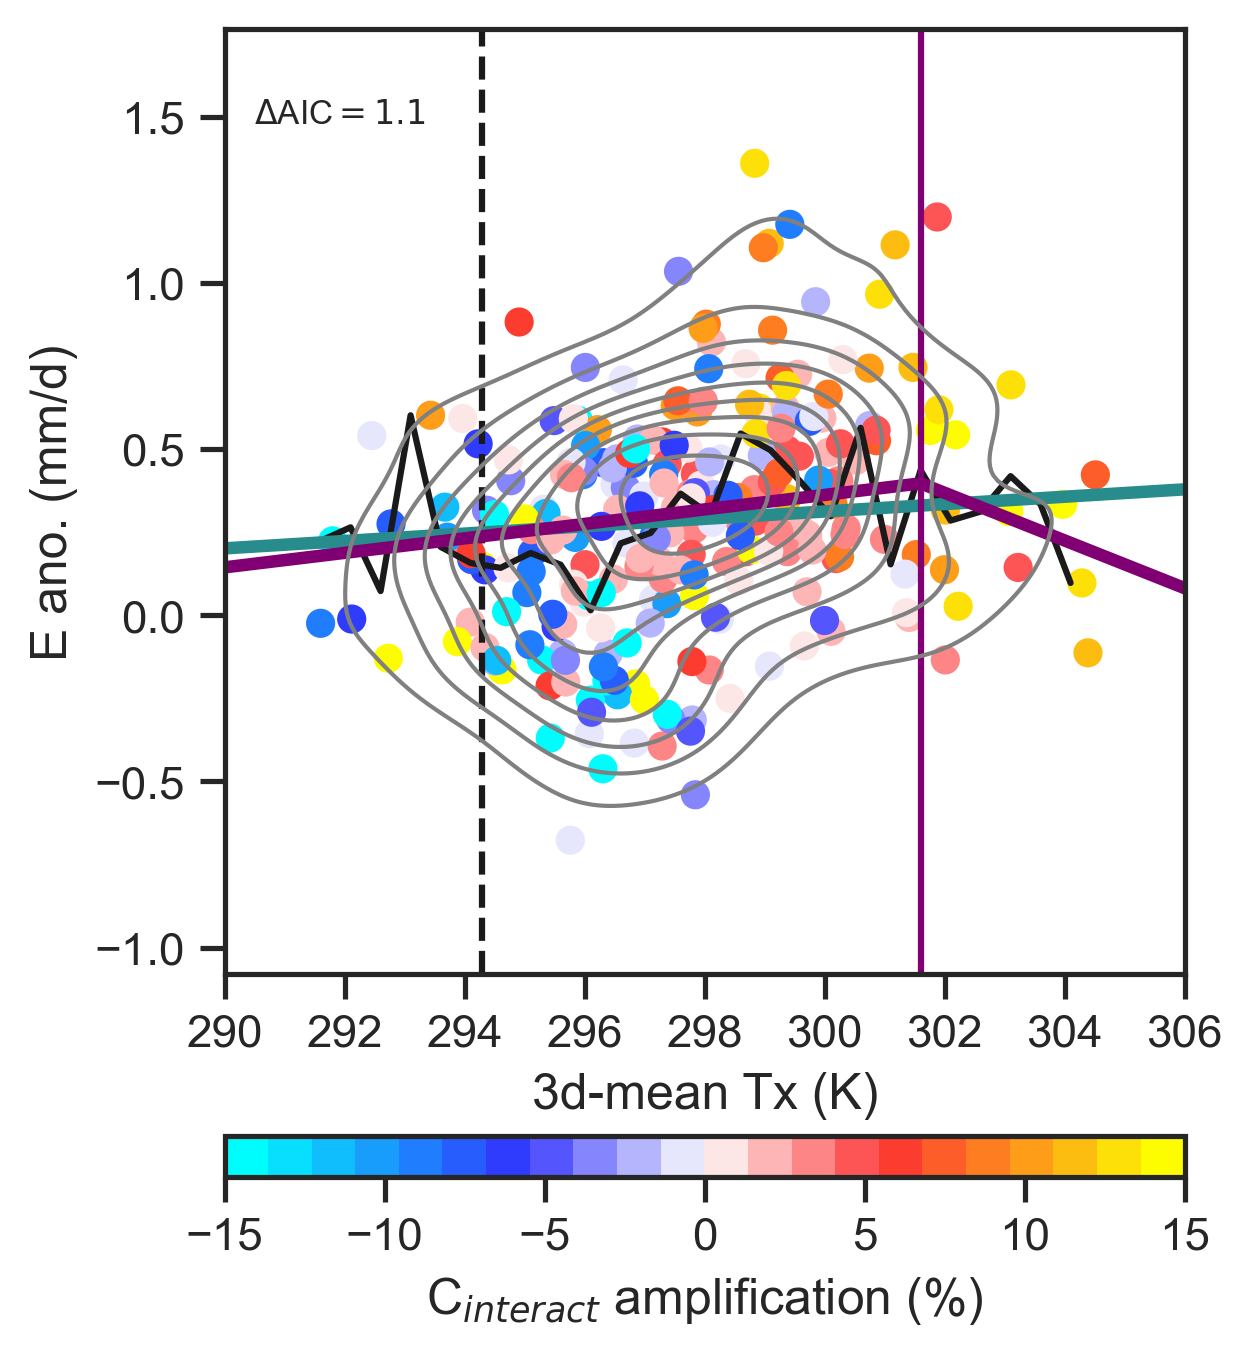

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

x1 = b_temp0[HW_flag]/(b_temp1[HW_flag]+b_temp2[HW_flag])*100

x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = evap_region_re_de[JJA_index][HW_flag]*1000

index_where = np.where((y<=2023)&(y>=1979))[0]
xxx = x[index_where]
yyy = z[index_where]
ccc = x1[index_where]
yearyear = y[index_where]

nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
ccc = ccc[nan_index]
yearyear = y[nan_index]
# bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig_quantile(xx, xxx,yyy,yearyear)



#################
xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)


fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis

im = ax1.scatter(xxx,yyy,c= ccc,cmap=cmaps.cmp_flux,vmin=-15,vmax=15)
ax1.set_ylabel('E ano. (mm/d)')
cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label=r'C$_{interact}$ amplification (%)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')


plt.subplots_adjust(left=0.2)
# ax1.set_yticks(np.arange(-0.4,1.2,0.2))
# ax1.set_ylim(-0.3,1)



sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidths=1,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)
ax1.axvline(basevalue1_0,color='k',linestyle = '--')


ax1.plot(xx_temp_median,yy_temp_median,c='k',label='50th quantile')
xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
########fitting
xx = np.arange(14,35,0.01)*1.0+272

params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l



ax1.plot(xx, y_pred_l1, label='Linear',linestyle='-',c=l_color,linewidth=3)
ax1.plot(xx, y_pred_piecewise1, label='Segmented',linestyle='-',c=p_color,linewidth=3)
ax1.text(0.03,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))
ax1.axvline(params_piecewise[0],color=p_color,linestyle = '-')


xx_new = np.arange(290,307)
# ax1.legend(fontsize=9,loc='center left',bbox_to_anchor=(0.0, 0.7))
ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')
xticks = ax1.get_xticks()
# ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)
print('1979~2023')

# critical soil moisture

In [ ]:
def piecewise_linear_sig_SM(xx, x0, y0,yearyear):

    def piecewise_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: y0])

    # Number of bootstrap samples
    n_bootstraps = 100

    # Container to hold the bootstrap slope estimates
    bootstrap_cp = []
    bootstrap_s2 = []
    bootstrap_y_linear = []
    bootstrap_y_piece = []
    bootstrap_dr2 = []
    bootstrap_dAIC = []
    bootstrap_r2_l = []
    bootstrap_r2_p = []
    bootstrap_s = []

    for ii in range(n_bootstraps):
    #     # for i in range(n_bootstraps):
        for i_year in range(1979,2024):


            bootstrap_sample = np.copy(range(len(x0)))

            # Resample with replacement of i_year
            indices_to_replace = np.where(yearyear==i_year)[0]
            indices_rest = [i for i in np.arange(len(x0)) if i not in indices_to_replace]

            # Replace the selected indices with new values from the rest data
            bootstrap_sample[indices_to_replace] = np.random.choice(indices_rest, size=len(indices_to_replace), replace=False)
        

            indices = bootstrap_sample
            xxx = x0[indices]
            yyy = y0[indices]
            
            try:
                params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
            except RuntimeError as e:
                continue
            y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
            y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
            r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
            slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
            y_pred_l = slope*xxx+int
            y_pred_l1 = slope*xx+int

            r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
            dr2 = r2_piecewise-r2_l

            aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
            aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
            

            DAIC = aic_segmented-aic_l
            # Store the slope estimate
            bootstrap_cp.append(params_piecewise[0])
            bootstrap_s2.append(params_piecewise[3])
            bootstrap_y_linear.append(y_pred_l1)
            bootstrap_y_piece.append(y_pred_piecewise1)
            bootstrap_dr2.append(dr2)
            bootstrap_dAIC.append(DAIC)
            bootstrap_r2_l.append(r2_l)
            bootstrap_r2_p.append(r2_piecewise)
            bootstrap_s.append(slope)

    return np.array(bootstrap_cp),np.array(bootstrap_s2),np.array(bootstrap_y_linear),np.array(bootstrap_y_piece),np.array(bootstrap_dr2),np.array(bootstrap_dAIC),np.array(bootstrap_r2_l),np.array(bootstrap_r2_p),np.array(bootstrap_s)

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
The following kwargs were not used by contour: 'linewidth'


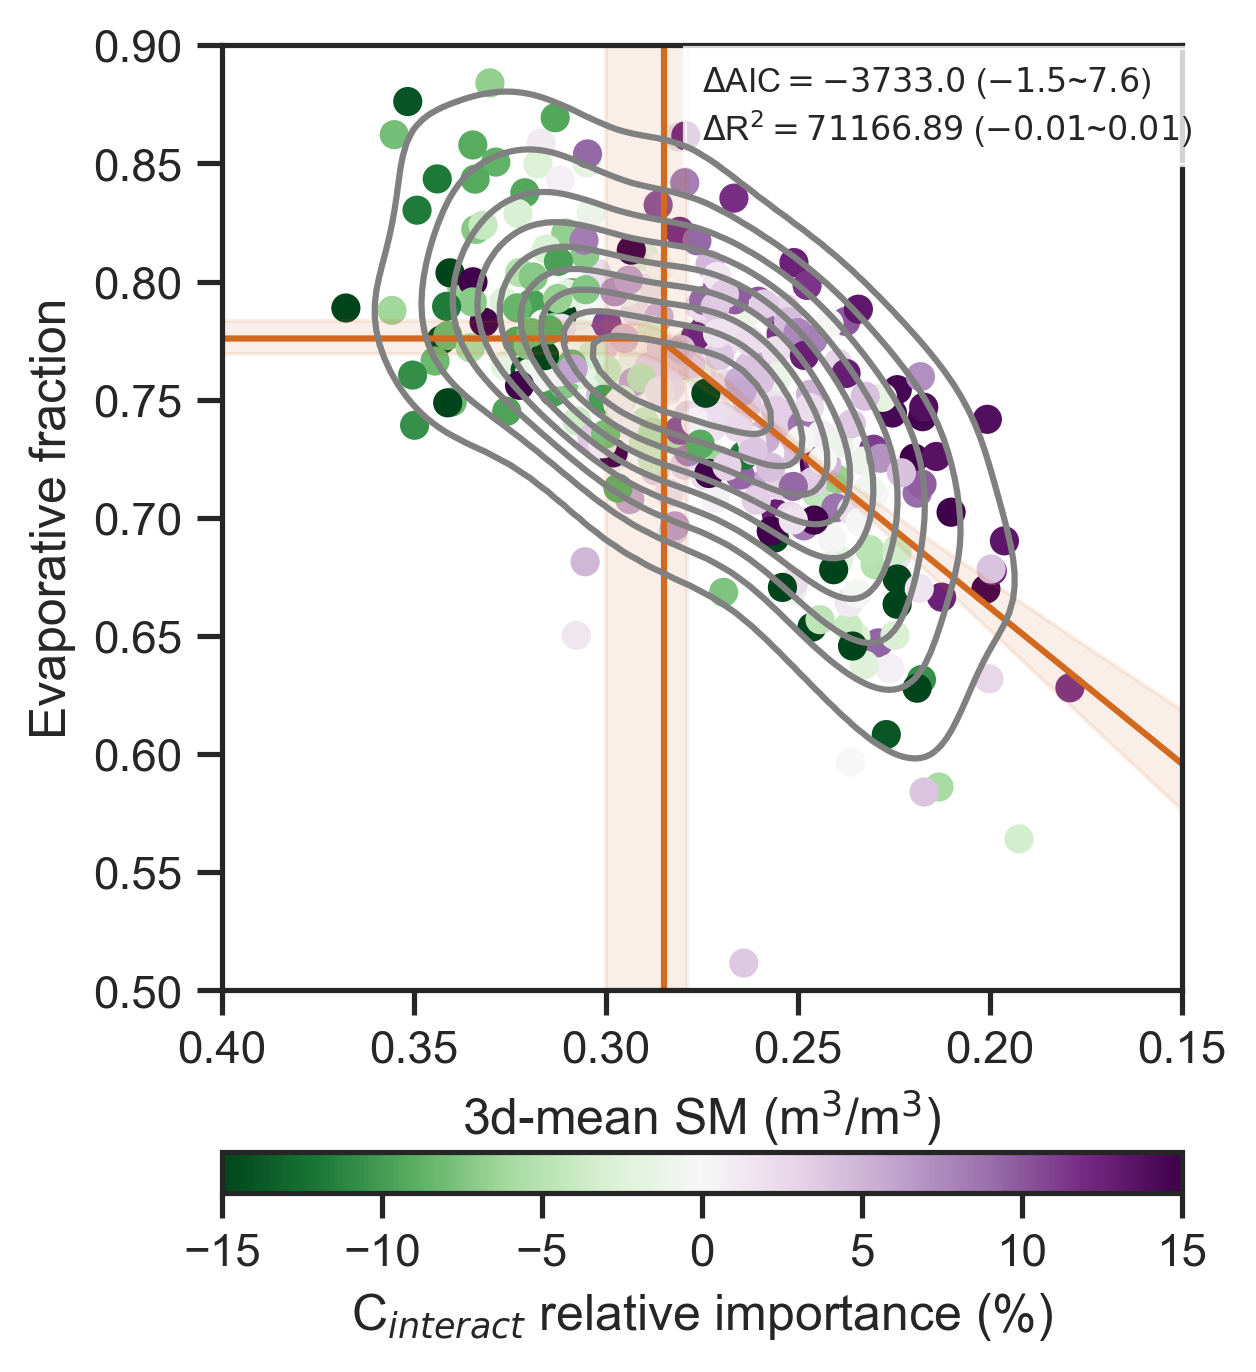

In [ ]:
xx = np.arange(0,0.45,0.005)

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: y0])

x = SM_region[JJA_index][HW_flag]
y = EF_region[JJA_index][HW_flag]
z = b_temp0[HW_flag]/(b_temp1[HW_flag]+b_temp2[HW_flag])*100
yy = year_era5_all[JJA_index][HW_flag]


index_where = np.where((year_era5_all[JJA_index]>=1979))[0]

fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis
im = ax1.scatter(x,y,c=z,cmap='PRGn_r',vmin=-15,vmax=15)
cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cax = fig.colorbar(im,label=r'C$_{interact}$ relative importance (%)',cax = cbaxes,orientation='horizontal' )
cbaxes.yaxis.set_ticks_position('right')
cbaxes.yaxis.set_label_position('right')

ax1.set_xlabel('3d-mean SM (m$^{3}$/m$^{3}$)')
ax1.set_ylabel('Evaporative fraction')

# plt.scatter(x[HW_flag==date_num],y[HW_flag==date_num],c=z[HW_flag==date_num],cmap=cmaps.GMT_panoply,vmin=-0.5,vmax=0.5,marker='*',s=200)

xxx = SM_region[JJA_index][HW_flag]
yyy = EF_region[JJA_index][HW_flag]

yearyear = year_era5_all[JJA_index][HW_flag]


params_piecewise, _ = curve_fit(piecewise_linear, xxx, yyy,bounds=([xx[0],-np.inf,-np.inf,-np.inf], [xx[-1],np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)


r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
dr2 = r2_piecewise-r2_l
aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)


y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int
r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)


aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l
dr2 = r2_piecewise-r2_l

bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig_SM(xx, xxx,yyy,yearyear)
sns.kdeplot(xxx ,yyy,levels=np.arange(0.1,1.0,0.1),linewidth=1,linestyles='-',alpha=1,bw_adjust=1,zorder=400,color='grey',ax=ax1)


ax1.plot( xx,y_pred_piecewise1, label='Evaporative curve: $r^{2}$'+f'={np.round(r2_piecewise,2)}'+', $x_{0}$'+f'={np.round(params_piecewise[0],2)}'+', $y_{0}$'+f'={np.round(params_piecewise[1],2)}',linestyle='-',c='chocolate')

ax1.fill_between(xx,np.nanpercentile(bootstrap_y_piece,0.5,axis=0),np.nanpercentile(bootstrap_y_piece,99.5,axis=0),alpha=0.1,color='chocolate')

ax1.text(0.5,0.9,'${\Delta}$AIC$=$'+f'${np.round(DAIC,1)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dAIC,0.5),1)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dAIC,99.5),1)}$'+')'+'\n${\Delta}$R$^{2}=$'+f'${np.round(dr2,2)}$'+' ('+f'${np.round(np.nanpercentile(bootstrap_dr2,0.5),2)}$'+'~'+f'${np.round(np.nanpercentile(bootstrap_dr2,99.5),2)}$'+')',transform=ax1.transAxes,fontsize=8,
         bbox=dict(facecolor='white', alpha=0.8))

ax1.axvline(np.nanpercentile(bootstrap_cp,50,axis=0),color='chocolate',linewidth=1.5)
ax1.axvspan(np.nanpercentile(bootstrap_cp,0.5,axis=0),np.nanpercentile(bootstrap_cp,99.5,axis=0),color='chocolate',alpha=0.1)

# ax1.legend(fontsize=9)
ax1.set_xlim(0.4,0.15)
ax1.set_ylim(0.5,0.9)
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)

# Probability of Tc being exceeded

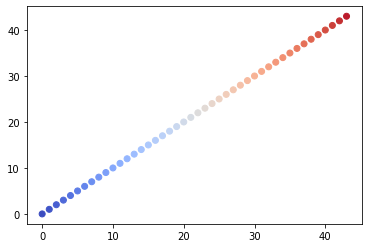

In [ ]:

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm')

# Generate 35 evenly spaced colors
num_colors = 44
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
im = plt.scatter(np.arange(num_colors),np.arange(num_colors),c=1979+np.arange(num_colors),cmap='coolwarm',vmin=1979,vmax=1979+num_colors )

In [ ]:

x = t2m_region[JJA_index]
y = year_era5_all[JJA_index]

per_T2m = []
for i in range(40):

    index_where = np.where((y<1979+i+5)&(y>=1979+i))[0]
    xxx = x[index_where]
    nan_index = np.where((~(np.isnan(xxx))))
    xxx = xxx[nan_index]

    data = xxx

    per_T2m.append(len(data[data>298.5])/len(data) *100)

# upper tail width HW period 

In [ ]:
year_number = 40

In [ ]:
x = (b_temp0/b_temp3*b_temp4)[HW_flag]
y = year_era5_all[JJA_index][HW_flag]


allyear_interact_mean = []
for i in range(year_number ):

    index_where = np.where((y<1979+i+45-year_number )&(y>=1979+i))[0]
    xxx = x[index_where]
    nan_index = np.where((~(np.isnan(xxx))))
    xxx = xxx[nan_index]

    allyear_interact_mean.append(np.nanmean(xxx))
##########################333


x = (b_temp1/b_temp3*b_temp4)[HW_flag]
y = year_era5_all[JJA_index][HW_flag]


allyear_Z500_mean = []
for i in range(year_number ):

    index_where = np.where((y<1979+i+45-year_number )&(y>=1979+i))[0]
    xxx = x[index_where]
    nan_index = np.where((~(np.isnan(xxx))))
    xxx = xxx[nan_index]

    allyear_Z500_mean.append(np.nanmean(xxx))

##########################333
x = (b_temp2/b_temp3*b_temp4)[HW_flag]
y = year_era5_all[JJA_index][HW_flag]


allyear_SM_mean = []
for i in range(year_number ):

    index_where = np.where((y<1979+i+45-year_number )&(y>=1979+i))[0]
    xxx = x[index_where]
    nan_index = np.where((~(np.isnan(xxx))))
    xxx = xxx[nan_index]

    allyear_SM_mean.append(np.nanmean(xxx))


In [ ]:

x = t2m_region[JJA_index]
y = year_era5_all[JJA_index]

allyear_T_tail = []    
year_number = 40
for i in range(year_number ):

    index_where = np.where((y<1979+i+45-year_number )&(y>=1979+i))[0]
    xxx = x[index_where]


    nan_index = np.where((~(np.isnan(xxx))))
    xxx = xxx[nan_index]
    


    allyear_T_tail.append(0.5*np.nanpercentile(xxx,99)+0.5*np.nanpercentile(xxx,100)-np.nanpercentile(xxx,75))


LinregressResult(slope=0.05514968067620105, intercept=-105.1117880688756, rvalue=0.6074943940075364, pvalue=3.225406909792567e-05, stderr=0.011697864722856503)
LinregressResult(slope=0.0016388131347829856, intercept=-3.188970283977363, rvalue=0.43883921362017414, pvalue=0.004615425756866769, stderr=0.0005443547287083269)
LinregressResult(slope=0.05514968067620105, intercept=-105.1117880688756, rvalue=0.6074943940075364, pvalue=3.225406909792567e-05, stderr=0.011697864722856503)
LinregressResult(slope=-0.013317305491472222, intercept=28.592530628361192, rvalue=-0.4212525278988838, pvalue=0.006789296811083942, stderr=0.004651170100122592)
LinregressResult(slope=0.05514968067620105, intercept=-105.1117880688756, rvalue=0.6074943940075364, pvalue=3.225406909792567e-05, stderr=0.011697864722856503)
LinregressResult(slope=0.00726151848968393, intercept=-13.904031664906618, rvalue=0.4659787091591476, pvalue=0.0024424955749337324, stderr=0.0022367255197763055)


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


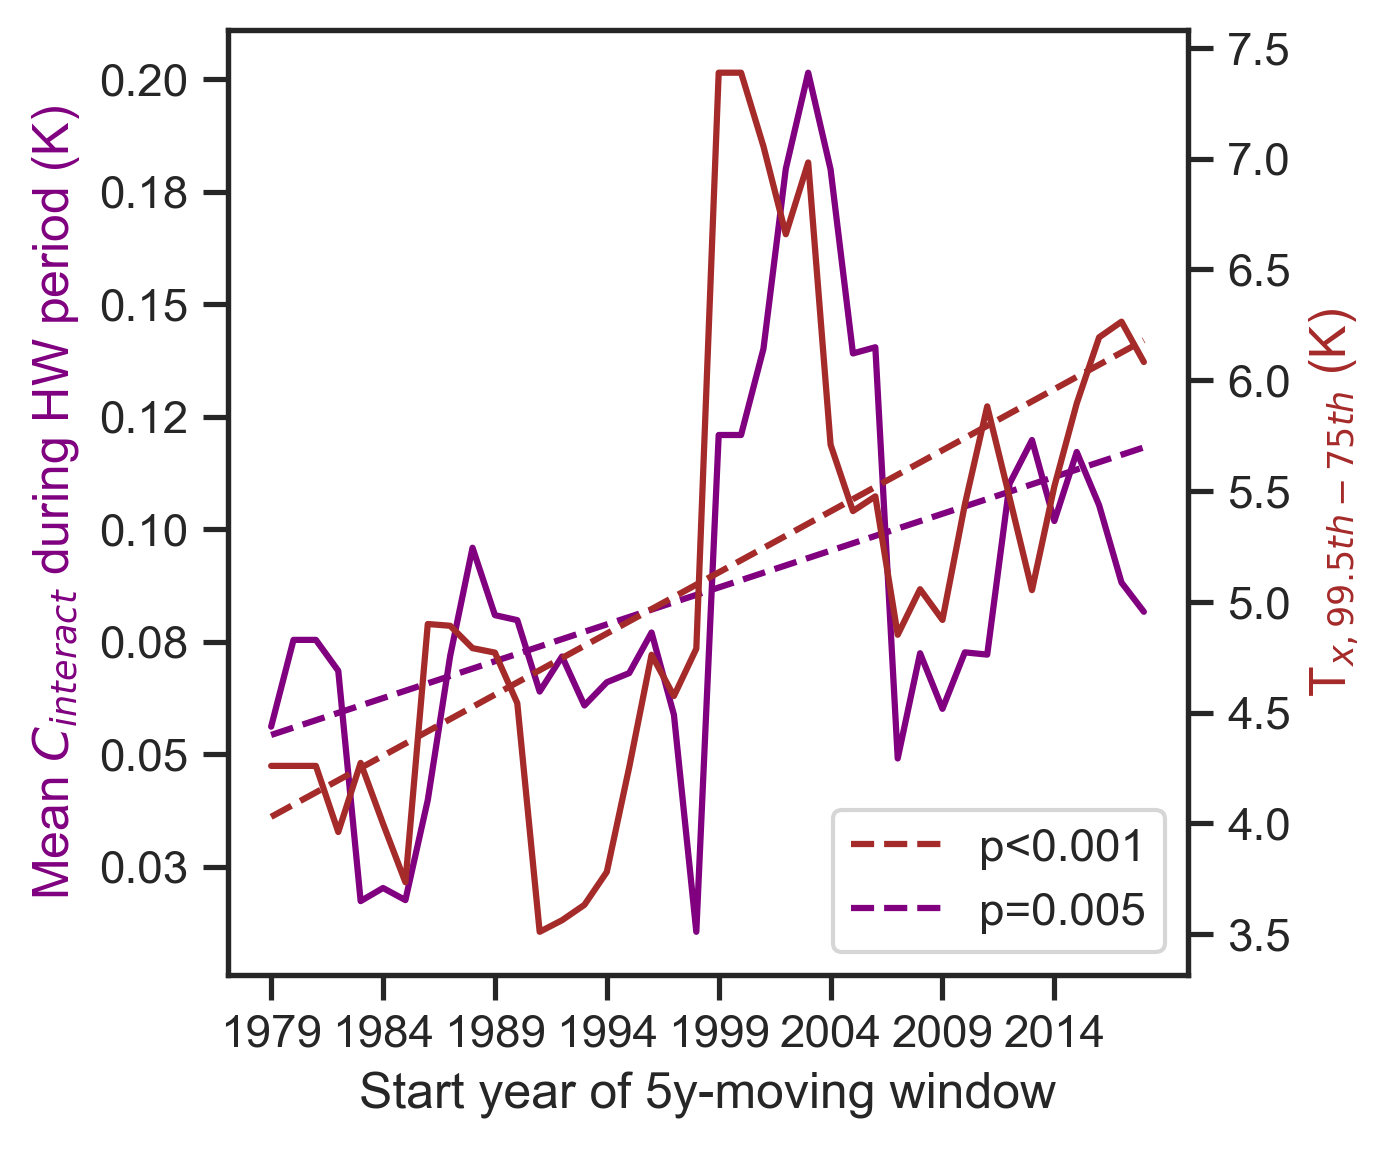

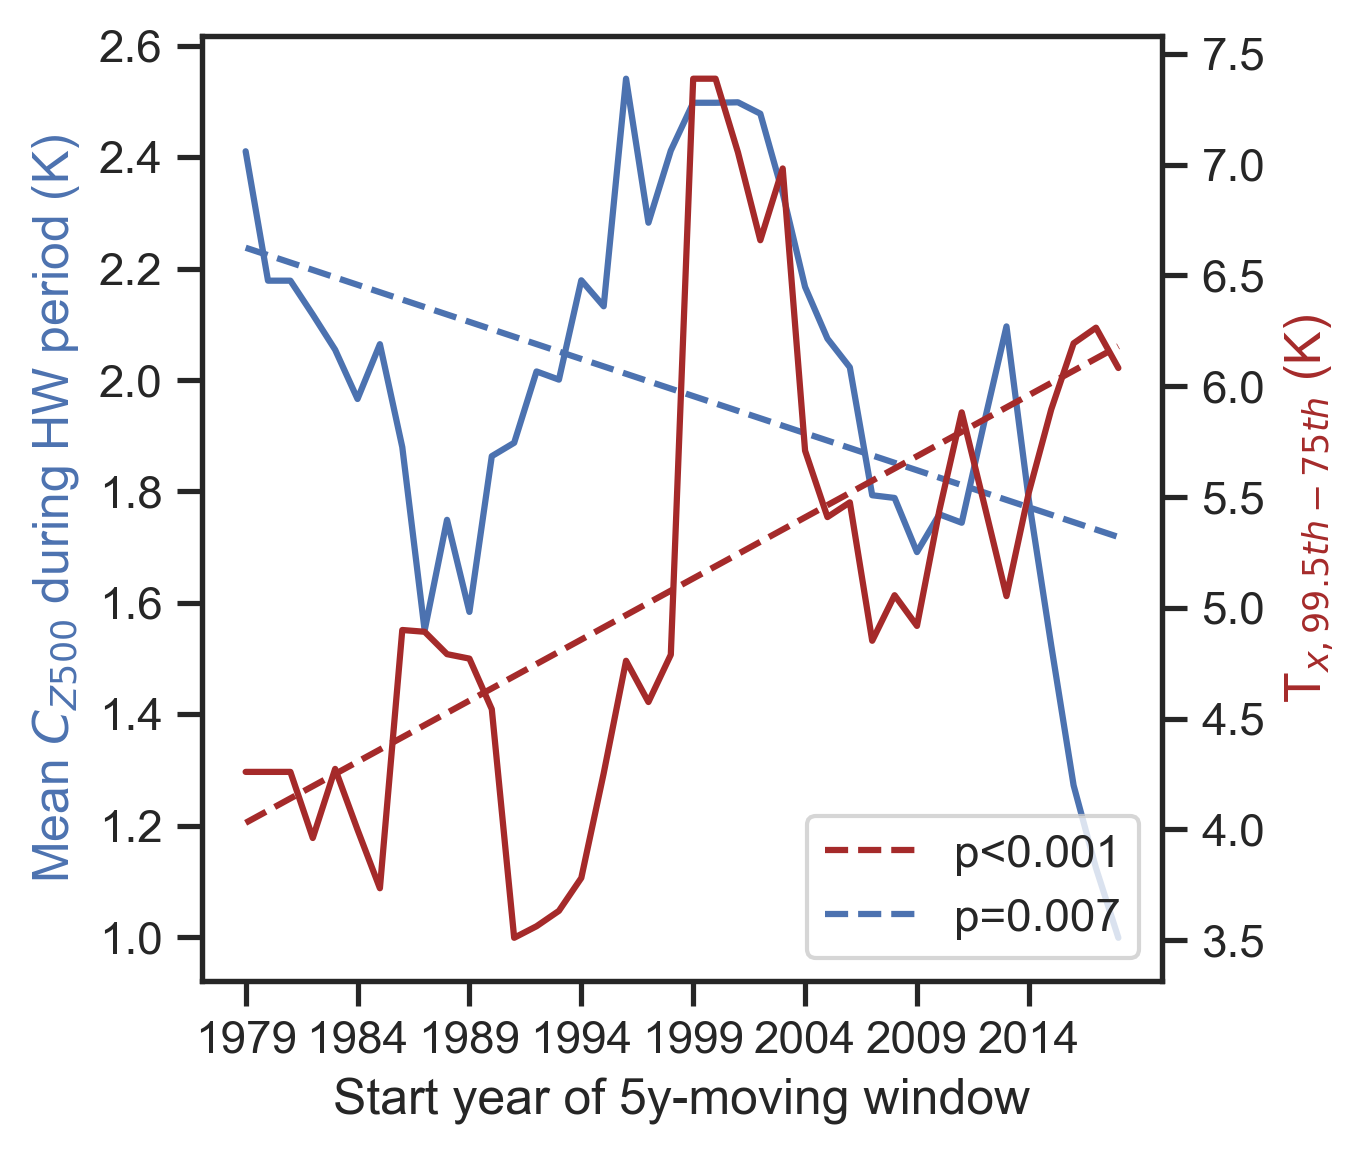

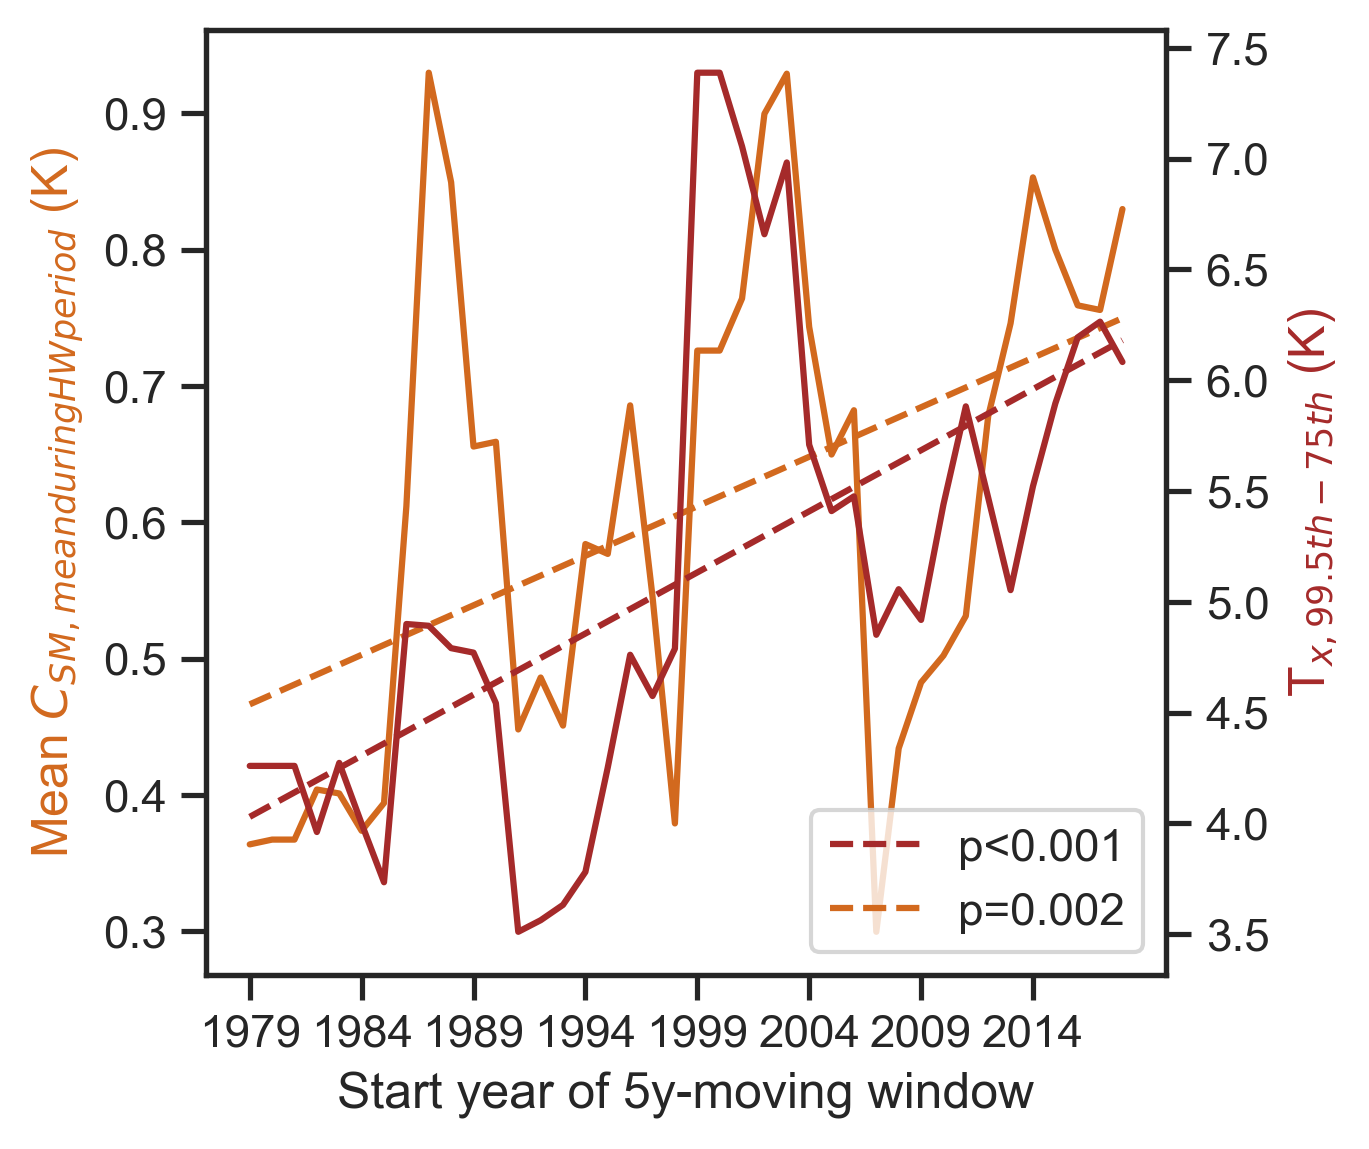

In [ ]:
# ##########

for iii,allyear_c ,label_xxx,color in zip(range(3),[allyear_interact_mean,allyear_Z500_mean,allyear_SM_mean],['Mean $C_{interact}$ during HW period','Mean $C_{Z500}$ during HW period','Mean $C_{SM, mean during HW period}$'],['purple','b','chocolate']):

    fig, ax2 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis
    ax1 = ax2.twinx()

    allyear_T_tail = np.array(allyear_T_tail)


    print(scipy.stats.linregress(1979+np.arange(year_number ),allyear_T_tail))
    slope,intercept,r2,p = scipy.stats.linregress(1979+np.arange(year_number ),allyear_T_tail)[:4]
    ax1.plot(1979+np.arange(year_number ),allyear_T_tail,c='brown')

    if p<0.001:
        ax1.plot(np.arange(1979,1979+year_number ),np.arange(1979,1979+year_number )*slope+intercept,c='brown',linestyle='--',label='p<0.001')
    else:
        ax1.plot(np.arange(1979,1979+year_number ),np.arange(1979,1979+year_number )*slope+intercept,c='brown',linestyle='--',label='p'+f'={np.round(p,3)}')





    print(scipy.stats.linregress(1979+np.arange(year_number ),allyear_c))
    slope,intercept,r2,p = scipy.stats.linregress(1979+np.arange(year_number ),allyear_c)[:4]
    if p<0.001:
        ax2.plot(np.arange(1979,1979+year_number ),np.arange(1979,1979+year_number )*slope+intercept,c=color,linestyle='--',label='p<0.001')
    else:
        ax2.plot(np.arange(1979,1979+year_number ),np.arange(1979,1979+year_number )*slope+intercept,c=color,linestyle='--',label='p'+f'={np.round(p,3)}')
    ax2.plot(1979+np.arange(year_number ),allyear_c,c=color)


    plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)
    ax1.set_ylabel('T$_{x,99.5th-75th}$ (K)',color='brown')
    ax2.set_ylabel(label_xxx+' (K)',color=color)


    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2,loc=4)

    plt.xticks(1979+np.arange(40)[::5])
    # ax1.set_ylim(0,6)
    ax2.set_xlabel('Start year of 5y-moving window')
    if iii==0:
        ax2.set_yticklabels([f'{tick:.2f}'for tick in ax2.get_yticks()])
    else:
        ax2.set_yticklabels([f'{tick:.1f}'for tick in ax2.get_yticks()])

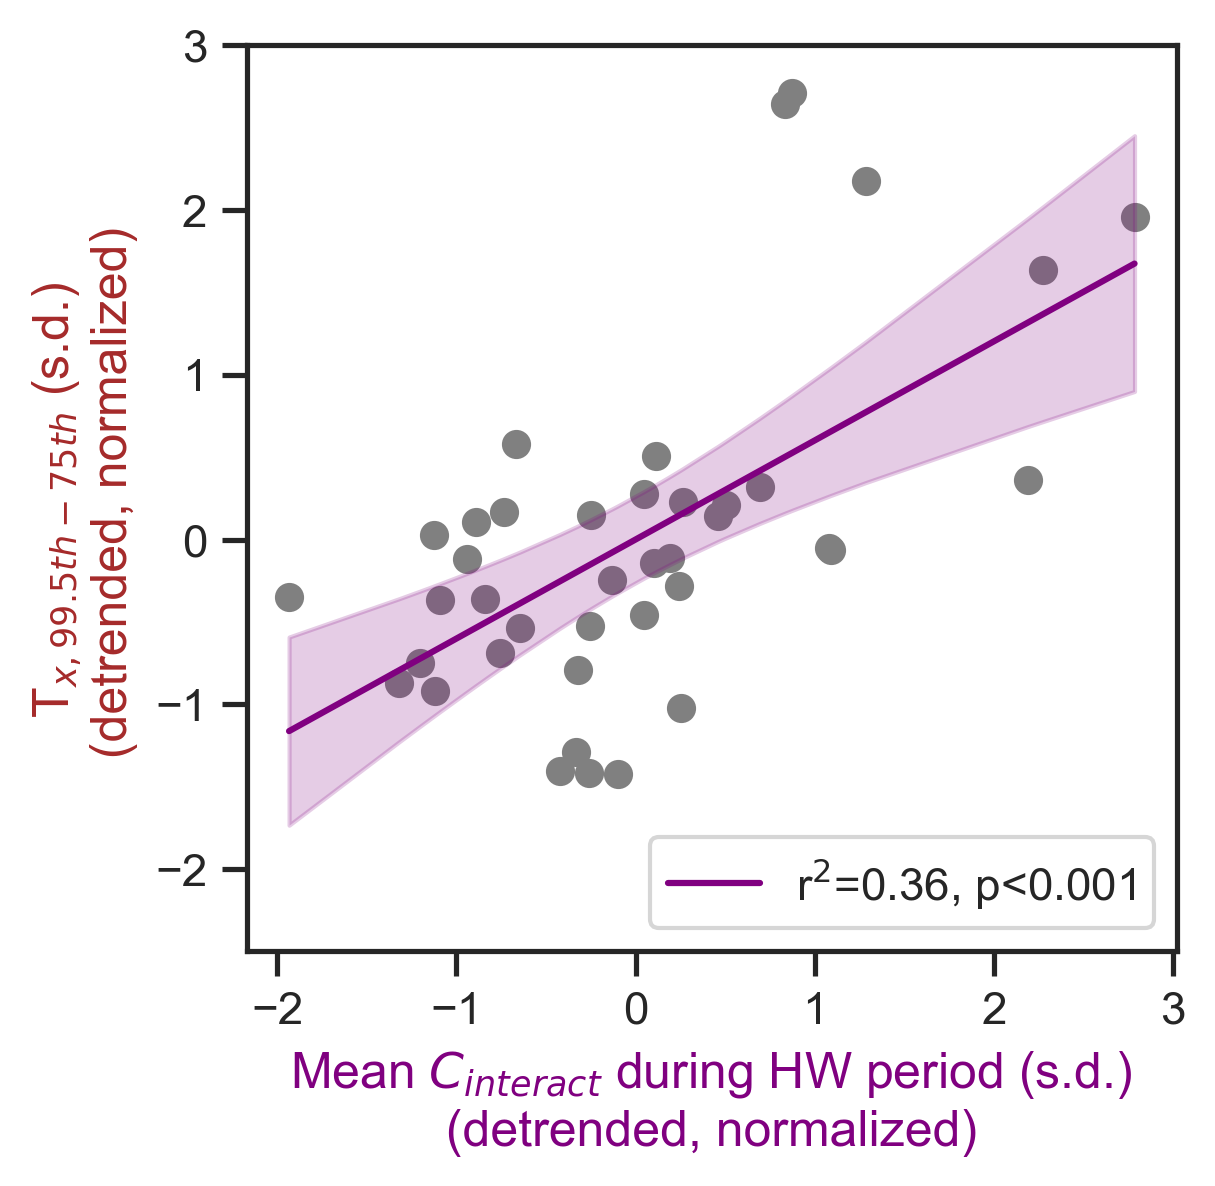

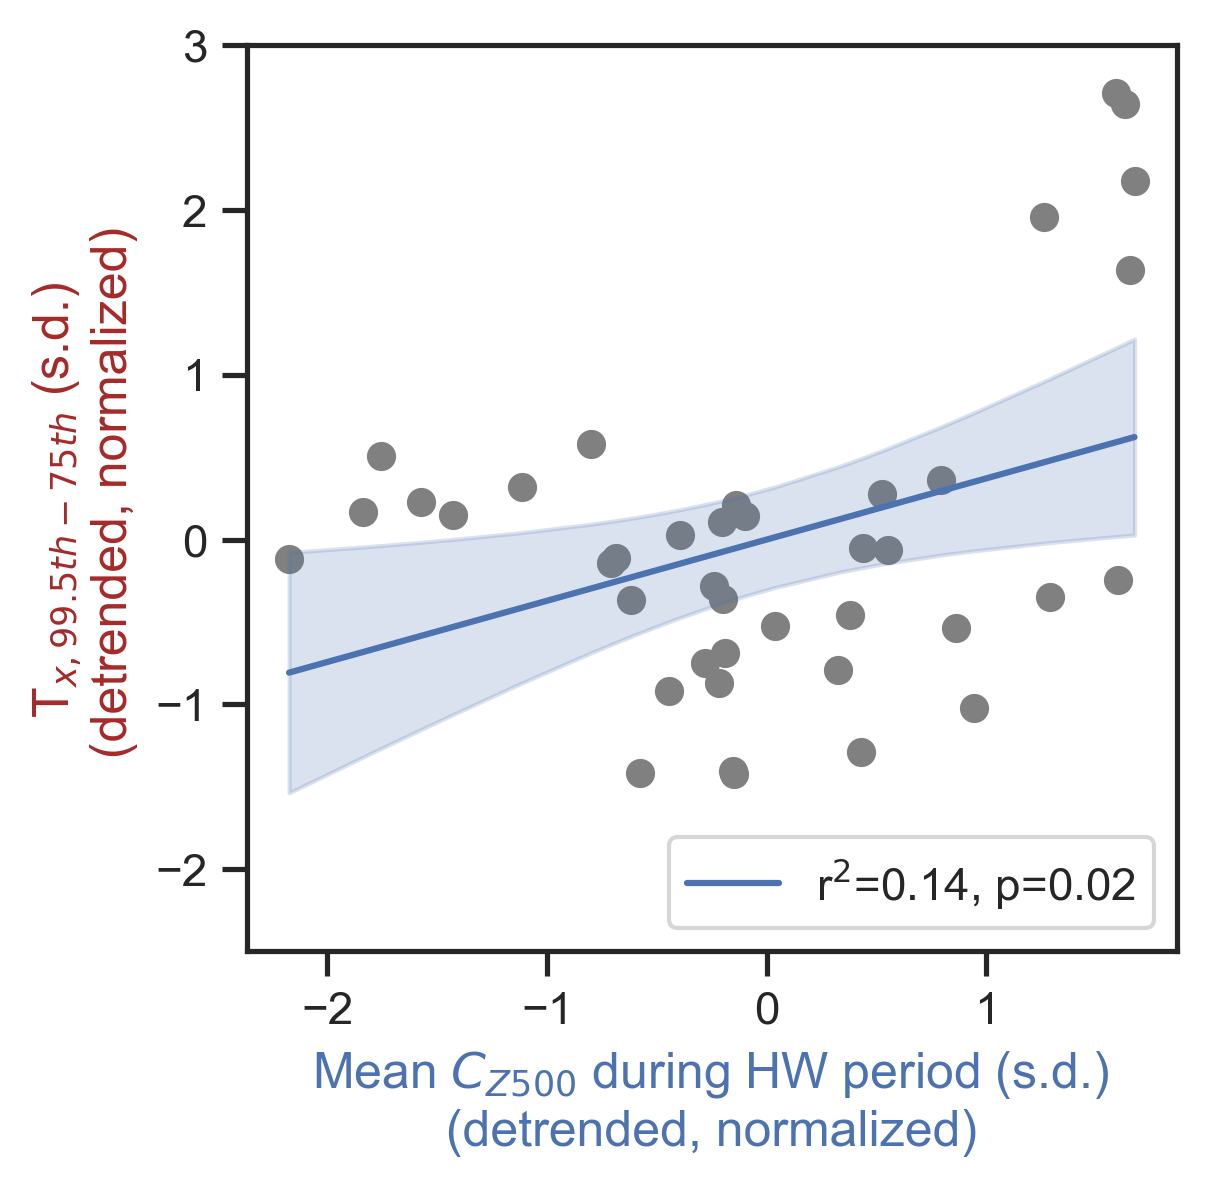

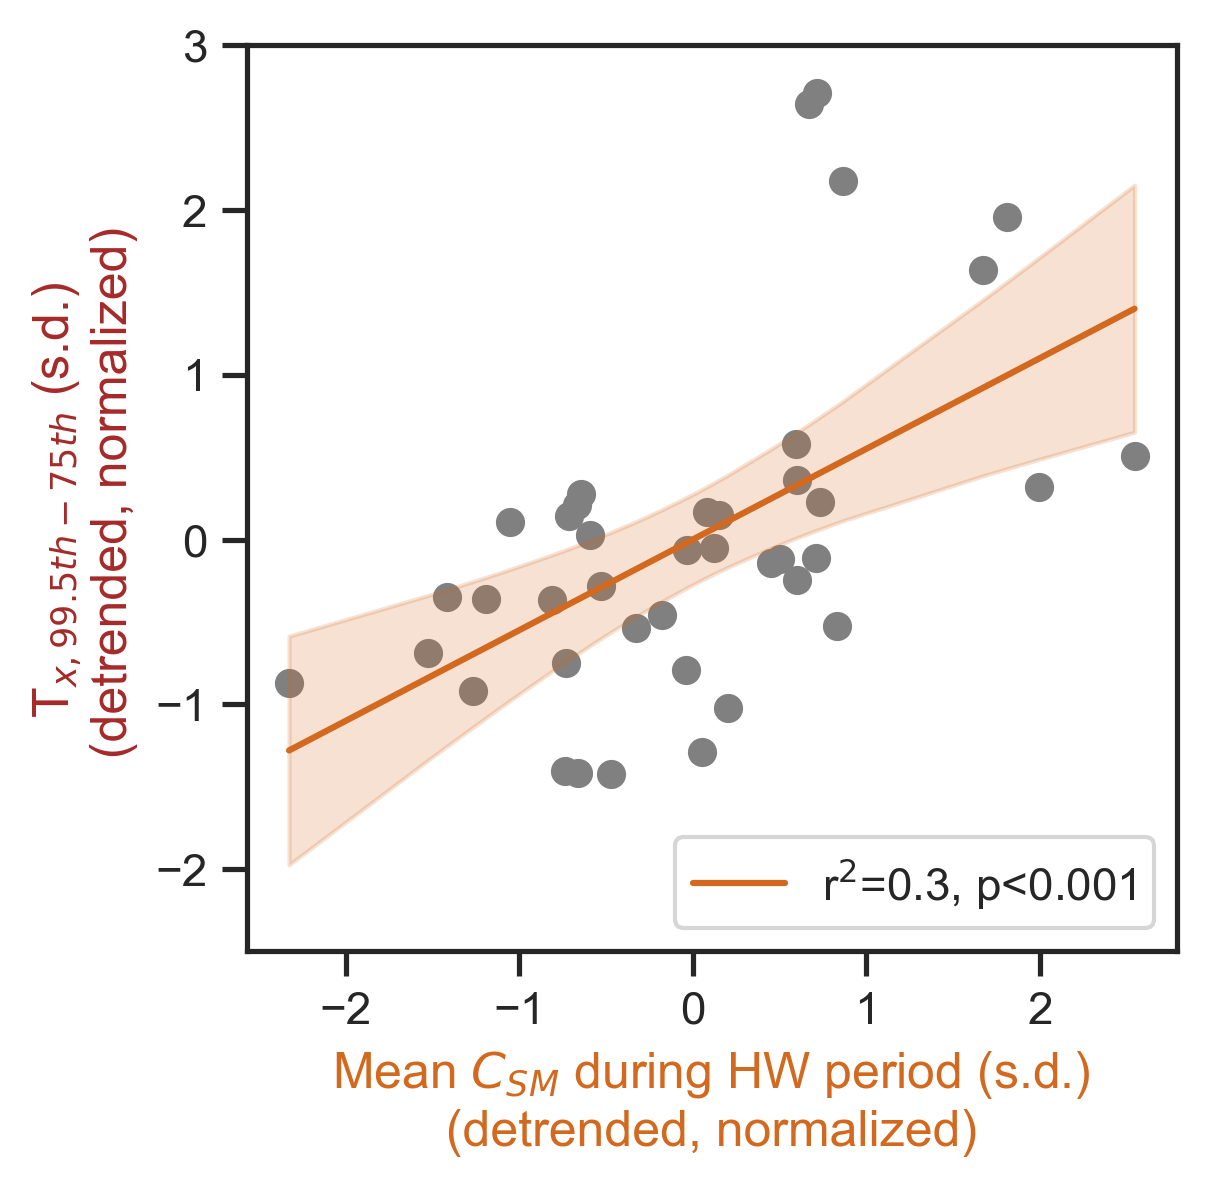

In [ ]:

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

    # Generate some example data
for color_i,xxx ,label_xxx in zip(['purple','b','chocolate'],[allyear_interact_mean,allyear_Z500_mean,allyear_SM_mean],['Mean $C_{interact}$ during HW period','Mean $C_{Z500}$ during HW period','Mean $C_{SM}$ during HW period']):
    # xxx = allyear_interact_mean
    yyy = allyear_T_tail
    xxx = signal.detrend(xxx)
    yyy = signal.detrend(yyy)

    xxx = (xxx-np.nanmean(xxx))/(np.nanstd(xxx))
    yyy = (yyy-np.nanmean(yyy))/(np.nanstd(yyy))

    X = copy.deepcopy(np.array(xxx))
    Y = copy.deepcopy(np.array(yyy))



    # Adding a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X).fit()
    # Extract the slope and intercept
    intercept, slope = model.params

    # Generate the predicted y values
    X_values = X[:, 1]  # Remove the constant column
    y_pred = intercept + slope * X_values

    # Calculate confidence intervals for predictions
    pred = model.get_prediction(X)
    conf_int = pred.conf_int()


    p_value = model.pvalues[1]
    r_squared = model.rsquared

    xxx1 = X_values[np.argsort(X_values)]
    yyy0 = slope*xxx1 +intercept


    yyy1 = conf_int[:, 0][np.argsort(X_values)]
    yyy2 = conf_int[:, 1][np.argsort(X_values)]
    fig, ax = plt.subplots(figsize=(4.,4),dpi=300)

    plt.scatter(xxx,yyy,color='grey')
    if p_value<0.001:
        plt.plot(xxx1,yyy0, label= 'r$^{2}$'+f'={np.round(r_squared,2)}'+', p<0.001',linestyle='-',c=color_i)
    else:
        plt.plot(xxx1,yyy0, label= 'r$^{2}$'+f'={np.round(r_squared,2)}'+', p'+f'={np.round(p_value,2)}',linestyle='-',c=color_i)
    plt.fill_between(xxx1,yyy1,yyy2,alpha=0.2,color=color_i)
    plt.ylabel('T$_{x,99.5th-75th}$ (s.d.) \n (detrended, normalized)',color='brown')
    plt.xlabel(label_xxx+' (s.d.) \n (detrended, normalized) ',color=color_i)
    plt.legend(loc=4)
    # plt.xlim(3.5,8)
    plt.ylim(-2.5,3)

# constraint

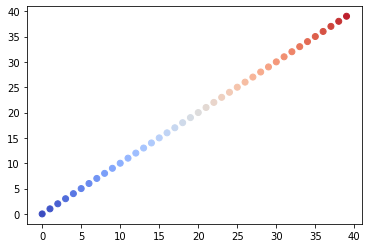

In [ ]:

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm')

# Generate 35 evenly spaced colors
num_colors = 40
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]
im = plt.scatter(np.arange(num_colors),np.arange(num_colors),c=1979+np.arange(num_colors),cmap='coolwarm',vmin=1979,vmax=1979+num_colors )

In [ ]:
len(per_T2m)

40

40


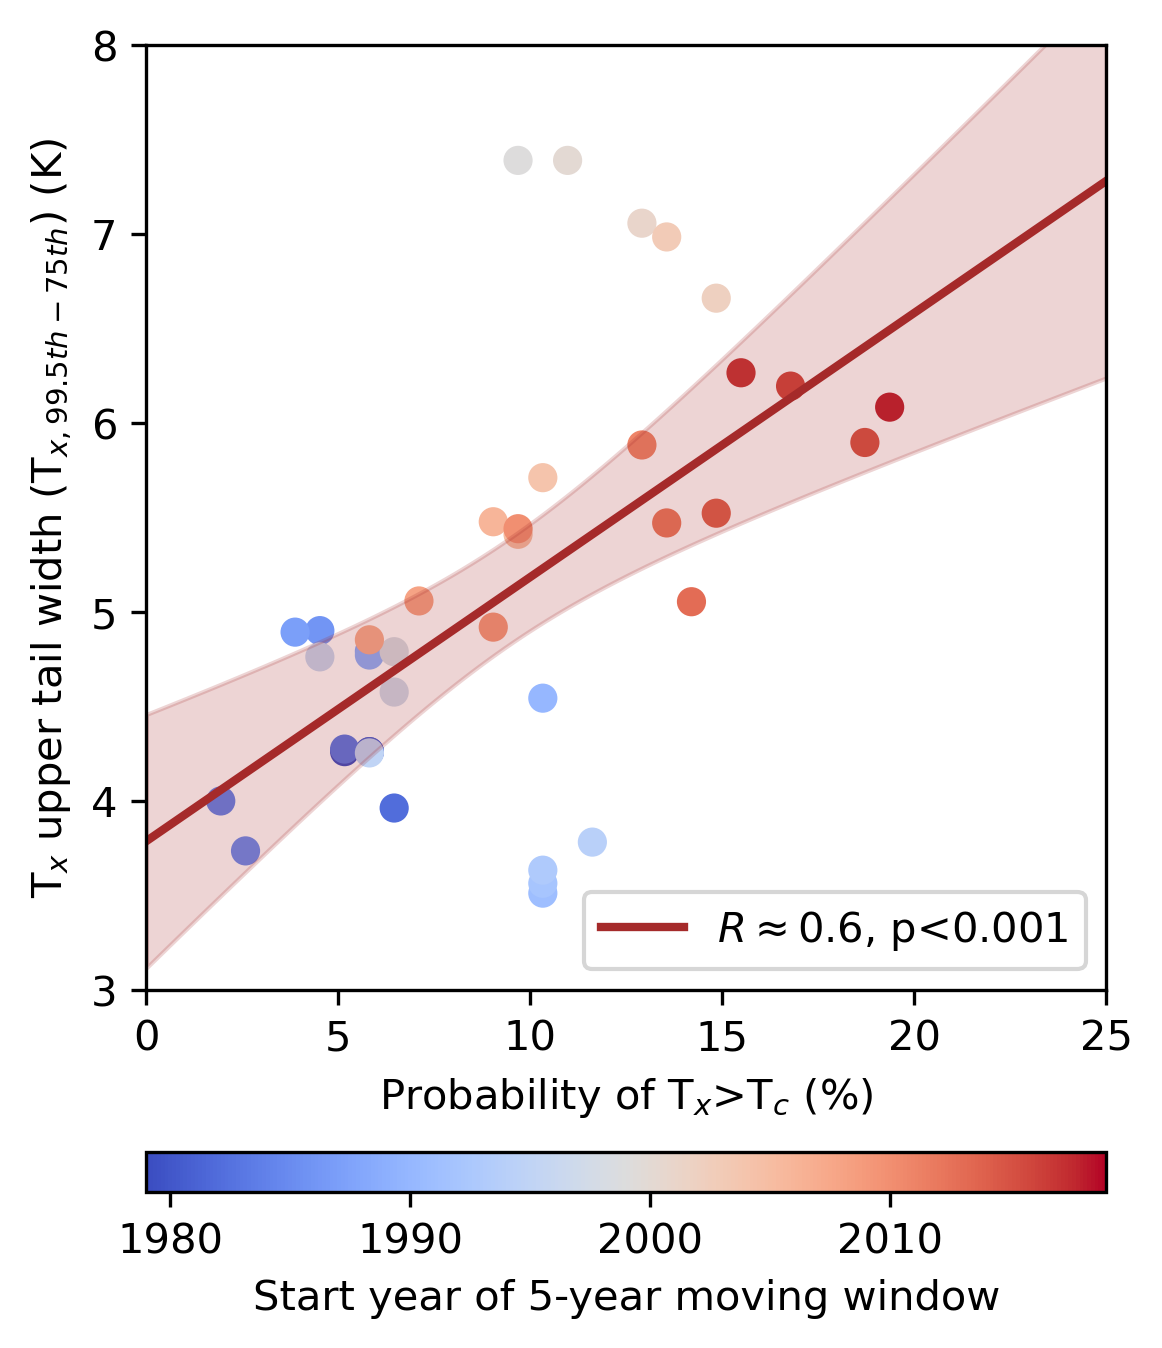

In [ ]:

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

    # Generate some example data
for color_i,xxx ,label_xxx in zip(['brown'],[per_T2m],['Probability of Tx>Tc']):
    # xxx = allyear_interact_mean
    yyy = allyear_T_tail

    print(len(xxx))


    X = copy.deepcopy(np.array(xxx))
    Y = copy.deepcopy(np.array(yyy))



    # Adding a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X).fit()
    # Extract the slope and intercept
    intercept, slope = model.params

    # Generate the predicted y values
    X_values = X[:, 1]  # Remove the constant column
    y_pred = intercept + slope * X_values

    # Calculate confidence intervals for predictions
    pred = model.get_prediction(X)
    conf_int = pred.conf_int()


    p_value = model.pvalues[1]
    r_squared = model.rsquared


    xxx1 = np.linspace(0, 25, 200)  # your desired x-axis
    yyy0 = slope*xxx1 +intercept
    X_pred = sm.add_constant(xxx1)   # add intercept
    y_pred_extended = model.predict(X_pred)

    # Confidence intervals over the extended range
    pred_extended = model.get_prediction(X_pred)
    conf_int_extended = pred_extended.conf_int()
    yyy1 = conf_int_extended[:, 0]
    yyy2 = conf_int_extended[:, 1]

    fig, ax = plt.subplots(figsize=(4.,4.5),dpi=300)
    plt.subplots_adjust(left=0.2)
    plt.scatter(xxx,yyy,c=1979+np.arange(num_colors),cmap='coolwarm',vmin=1979,vmax=1979+num_colors )

    # plt.scatter(xxx[-1],yyy[-1],color='brown',marker='*',s=100)
    if p_value<0.001:
        plt.plot(xxx1,yyy0,linewidth=2, label= r'$R \approx$'+f'{np.round(r_squared**0.5,1)}'+', p<0.001',linestyle='-',c=color_i)
    else:
        plt.plot(xxx1,yyy0,linewidth=2,  label= r'$R \approx$'+f'{np.round(r_squared**0.5,1)}'+', p$\approx$'+f'{np.round(p_value,2)}',linestyle='-',c=color_i)
    plt.fill_between(xxx1,yyy1,yyy2,alpha=0.2,color=color_i)

    plt.ylabel('T$_{x}$ upper tail width (T$_{x,99.5th-75th}$) (K)')
    plt.xlabel('Probability of T$_{x}$>T$_{c}$ (%)')

    plt.legend(loc='lower right')
    plt.xlim(0,25)
    plt.ylim(3,8)
    # plt.xlim(0,25)
    
    cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
    cax = fig.colorbar(im,label='Start year of 5-year moving window',cax = cbaxes,orientation='horizontal' )
    cbaxes.yaxis.set_ticks_position('right')
    cbaxes.yaxis.set_label_position('right')
    plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)    

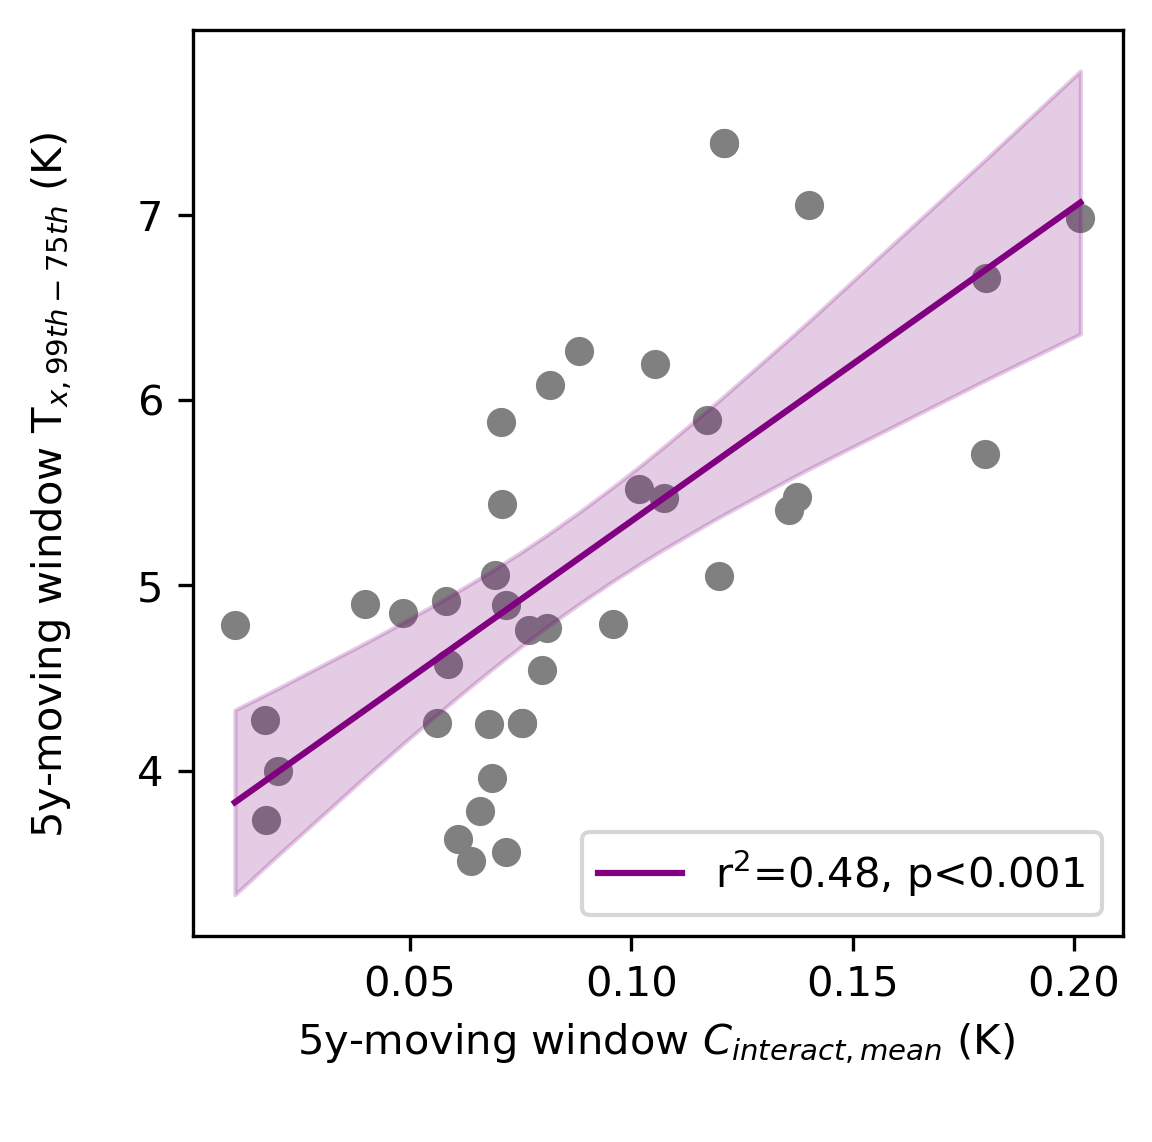

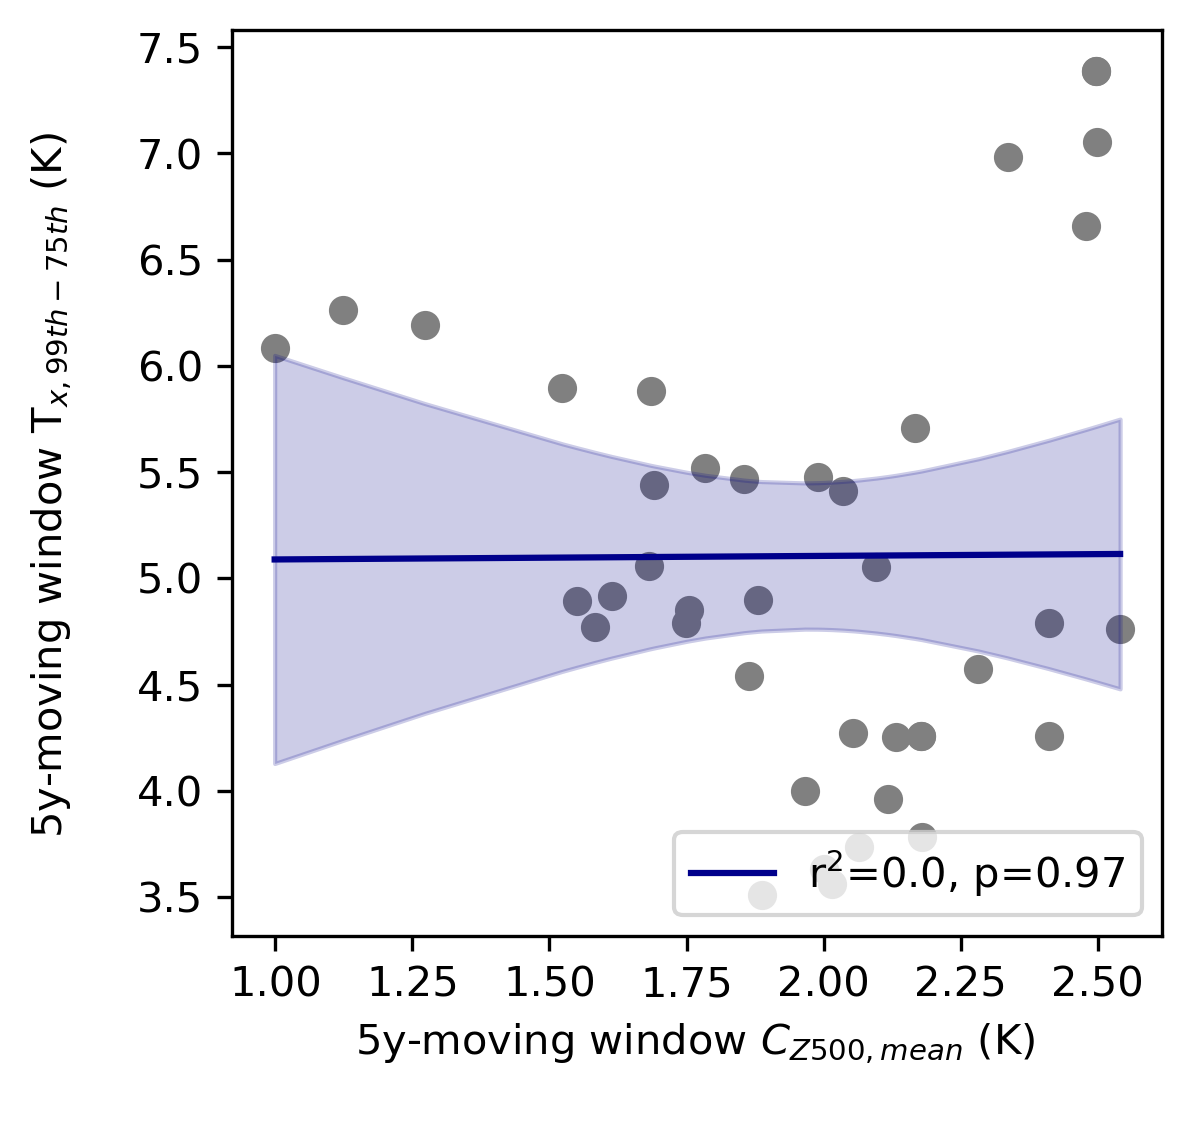

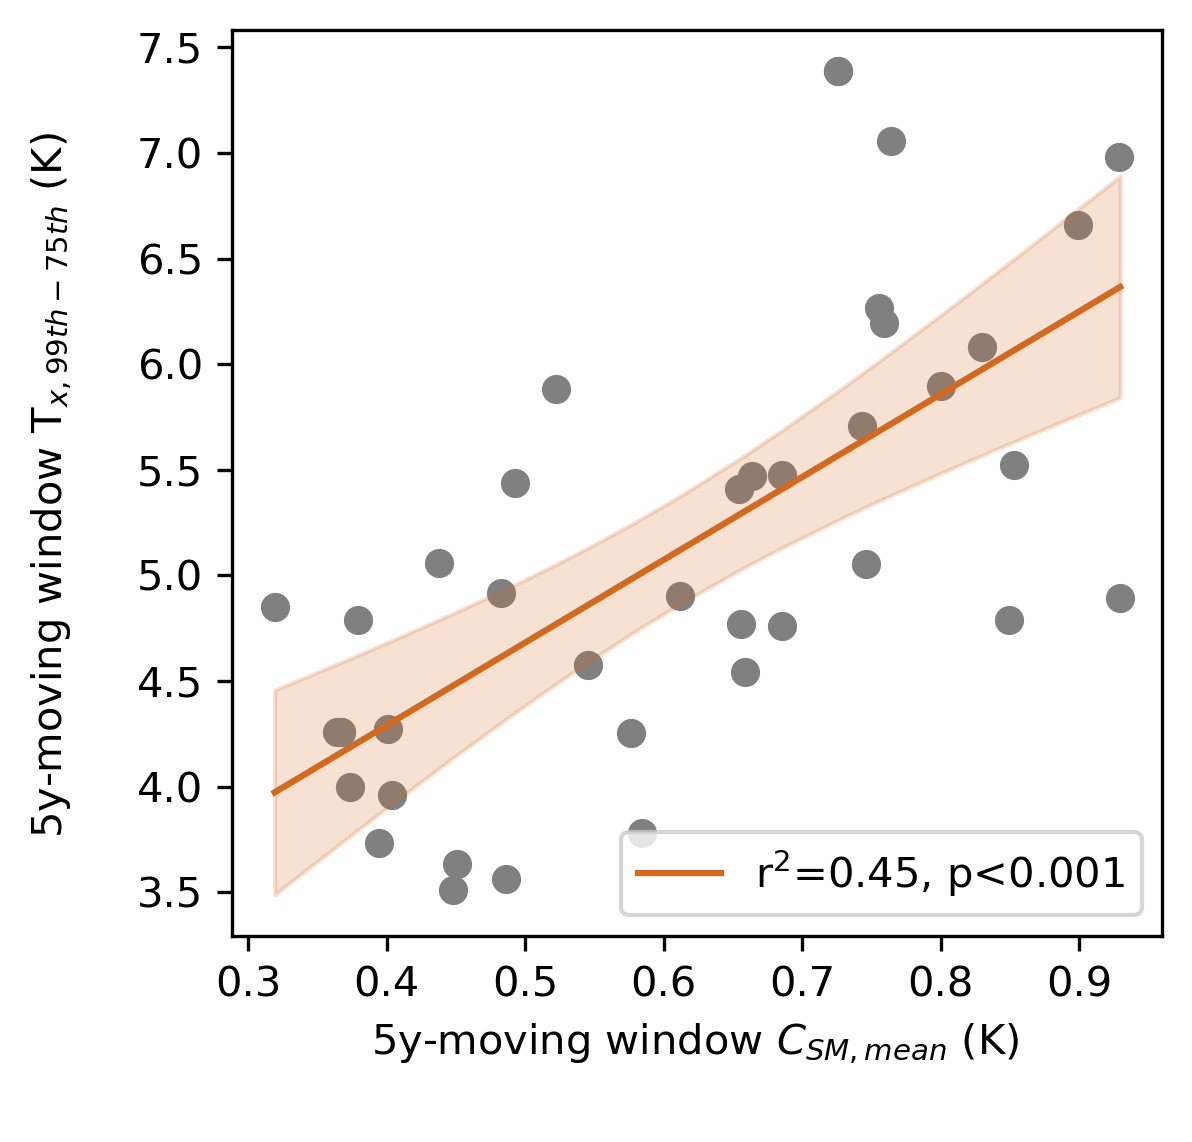

In [ ]:

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

    # Generate some example data
for color_i,xxx ,label_xxx in zip(['purple','darkblue','chocolate'],[allyear_interact_mean,allyear_Z500_mean,allyear_SM_mean],['$C_{interact,mean}$','$C_{Z500,mean}$','$C_{SM,mean}$']):
    # xxx = allyear_interact_mean
    yyy = allyear_T_tail
    # xxx = signal.detrend(xxx)
    # yyy = signal.detrend(yyy)

    X = copy.deepcopy(np.array(xxx))
    Y = copy.deepcopy(np.array(yyy))


    # Adding a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X).fit()
    # Extract the slope and intercept
    intercept, slope = model.params

    # Generate the predicted y values
    X_values = X[:, 1]  # Remove the constant column
    y_pred = intercept + slope * X_values

    # Calculate confidence intervals for predictions
    pred = model.get_prediction(X)
    conf_int = pred.conf_int()


    p_value = model.pvalues[1]
    r_squared = model.rsquared

    xxx1 = X_values[np.argsort(X_values)]
    yyy0 = slope*xxx1 +intercept


    yyy1 = conf_int[:, 0][np.argsort(X_values)]
    yyy2 = conf_int[:, 1][np.argsort(X_values)]
    fig, ax = plt.subplots(figsize=(4.,4),dpi=300)

    plt.scatter(xxx,yyy,color='grey')
    if p_value<0.001:
        plt.plot(xxx1,yyy0, label= 'r$^{2}$'+f'={np.round(r_squared,2)}'+', p<0.001',linestyle='-',c=color_i)
    else:
        plt.plot(xxx1,yyy0, label= 'r$^{2}$'+f'={np.round(r_squared,2)}'+', p'+f'={np.round(p_value,2)}',linestyle='-',c=color_i)
    plt.fill_between(xxx1,yyy1,yyy2,alpha=0.2,color=color_i)
    plt.ylabel('5y-moving window T$_{x,99th-75th}$ (K) \n')
    plt.xlabel('5y-moving window '+label_xxx+' (K) \n')
    plt.legend(loc=4)
    # plt.xlim(3.5,8)
    # plt.ylim(0,6)